
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0
Receiving objects: 100% (53/53), 32.99 KiB | 11.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.


/tmp/ipykernel_9299/3046165550.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


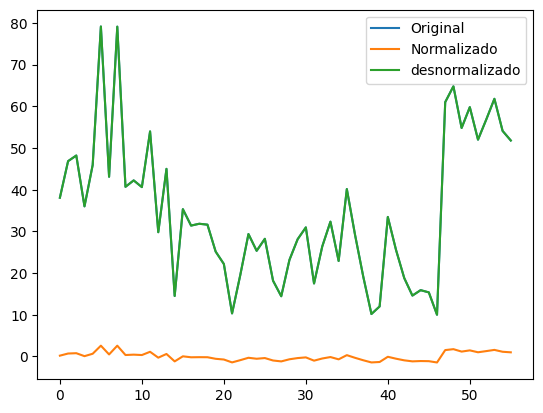

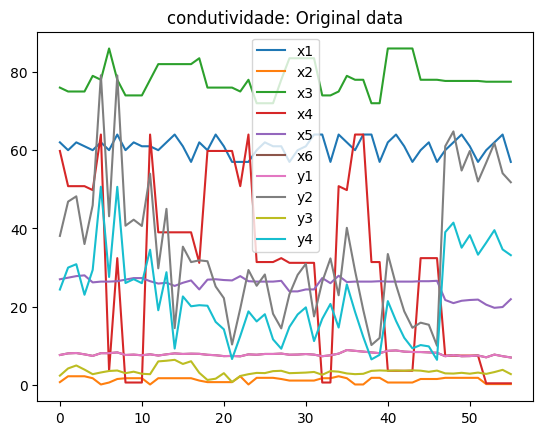

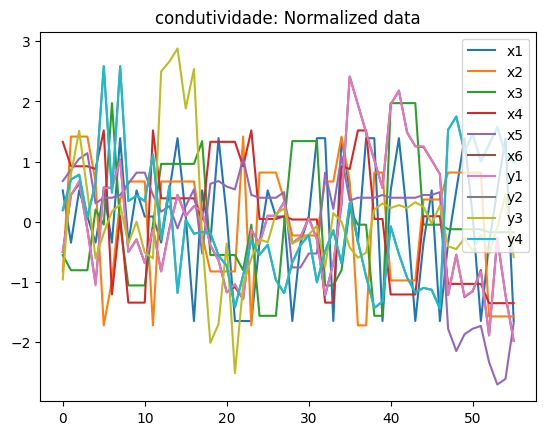

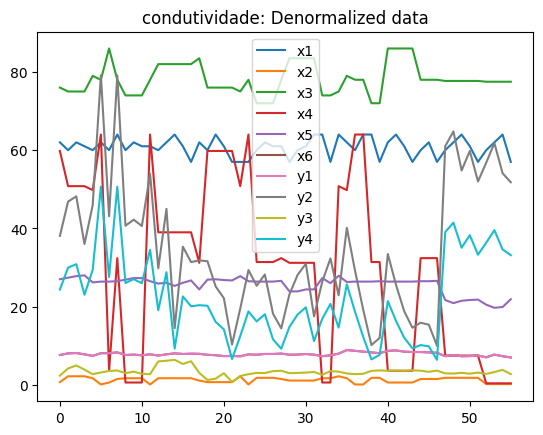

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5, x6  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5'], df['x6']

    input = np.vstack([x1, x2, x3, x4, x5, x6 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-26 15:17:44.656871: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 15:17:46.451419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 15:17:46.451531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 15:17:46.781401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 15:17:47.293937: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 15:17:47.294680: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [7]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=6,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [8]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [9]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[30], [25], [20], [25, 15], [20, 10], [35], [10, 5], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.2919630220001181
Stopped at epoch:  24
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.14329122100002678
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.14443936900011067
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.14806904000010945
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.14309940700013613
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.14304710000010346
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 7 +++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_4_0,0.802682,0.042073,0.272003,0.113631,58.097166,150.886597,43.267878,100.242487
model_1_4_1,0.820379,0.050042,0.243061,0.112349,52.886627,149.631354,44.988017,100.387455
model_1_4_2,0.834054,0.056512,0.196821,0.105684,48.860122,148.612329,47.736265,101.141240
model_1_4_3,0.844526,0.061790,0.138247,0.095089,45.776752,147.780946,51.217540,102.339371
model_1_4_4,0.852452,0.066068,0.071402,0.081713,43.443186,147.107101,55.190417,103.852159
model_1_4_5,0.858360,0.069486,-0.000441,0.066465,41.703819,146.568636,59.460375,105.576553
model_1_4_6,0.862675,0.072158,-0.074702,0.050070,40.433234,146.147859,63.874002,107.430750
model_1_4_23,0.864075,0.074114,-0.927428,-0.159374,40.020902,145.839734,114.555006,131.117494
model_1_4_22,0.864647,0.074500,-0.902728,-0.152982,39.852434,145.778998,113.086991,130.394544
model_1_4_21,0.865251,0.074902,-0.875592,-0.145974,39.674802,145.715554,111.474213,129.601982


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Elapsed time:  0.14720677699983753
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Elapsed time:  0.14232295000010708
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Elapsed time:  0.15003976899993177
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Elapsed time:  0.14954551400001037
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Elapsed time:  0.14485215099989546
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Elapsed time:  0.14561292799999137
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Elapsed time:  0.146849

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_5_0,0.887533,0.998817,0.923176,0.967047,33.114288,0.286727,20.038504,9.581680
model_1_5_24,0.894226,0.708451,0.474281,0.649377,31.143588,70.681200,137.126090,101.949402
model_1_5_23,0.896260,0.713714,0.486072,0.656678,30.544699,69.405226,134.050370,99.826509
model_1_5_22,0.898456,0.719462,0.498927,0.664641,29.897975,68.011798,130.697550,97.510943
model_1_5_21,0.900818,0.725726,0.512902,0.673306,29.202476,66.493034,127.052165,94.991430
model_1_5_20,0.903347,0.732542,0.528055,0.682711,28.457882,64.840674,123.099941,92.256798
model_1_5_1,0.904983,0.992293,0.913948,0.960271,27.976124,1.868358,22.445477,11.551703
model_1_5_19,0.906040,0.739943,0.544425,0.692889,27.665095,63.046485,118.829898,89.297563
model_1_5_18,0.908888,0.747961,0.562044,0.703866,26.826365,61.102638,114.234347,86.105777
model_1_5_17,0.911879,0.756629,0.580919,0.715660,25.945937,59.001329,109.311028,82.676451


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Elapsed time:  0.19563631599999098
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.19831541299981836
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.20214861799991013
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.17625214100007724
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.19710523999992802
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.2013063299998521
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.4418252

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_6_0,0.906054,0.763772,0.993789,0.884212,27.661065,90.072488,2.921455,49.060263
model_1_6_1,0.914880,0.769988,0.990493,0.885452,25.062333,87.702310,4.471353,48.534800
model_1_6_2,0.921367,0.773743,0.986154,0.884974,23.152256,86.270487,6.512393,48.737313
model_1_6_24,0.922030,0.741004,0.895743,0.822148,22.957191,98.753845,49.036063,75.357229
model_1_6_23,0.922604,0.742155,0.897495,0.823611,22.787941,98.314988,48.212053,74.737206
model_1_6_22,0.923226,0.743409,0.899422,0.825216,22.604987,97.836583,47.305803,74.057396
model_1_6_21,0.923895,0.744774,0.901539,0.826971,22.408064,97.316358,46.310248,73.313472
model_1_6_20,0.924611,0.746253,0.903861,0.828889,22.197110,96.752519,45.218060,72.501034
model_1_6_19,0.925374,0.747851,0.906403,0.830978,21.972402,96.143198,44.022228,71.615711
model_1_6_3,0.926033,0.775698,0.981096,0.883264,21.778549,85.524992,8.891278,49.462028


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Elapsed time:  0.2512963479998689
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Elapsed time:  0.22269052100000408
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Elapsed time:  0.18634171200005767
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Elapsed time:  0.17829428900017774
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Elapsed time:  0.29176905799999986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Elapsed time:  0.2773016219998681
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Elapsed time:  0.21320916

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_7_0,0.943869,0.977974,0.905973,0.957676,16.526914,9.321954,18.962692,13.858774
model_1_7_1,0.951315,0.975551,0.906454,0.956157,14.334467,10.347600,18.865775,14.356143
model_1_7_2,0.957068,0.972834,0.905809,0.954111,12.640529,11.497375,18.995769,15.026036
model_1_7_3,0.961480,0.969960,0.904353,0.951722,11.341701,12.713627,19.289402,15.808112
model_1_7_4,0.964830,0.967029,0.902330,0.949131,10.355371,13.954020,19.697345,16.656753
model_1_7_5,0.967343,0.964114,0.899930,0.946440,9.615437,15.187677,20.181386,17.537667
model_1_7_6,0.969198,0.961267,0.897299,0.943729,9.069130,16.392644,20.712026,18.425307
model_1_7_7,0.970539,0.958524,0.894547,0.941055,8.674370,17.553765,21.267036,19.301178
model_1_7_24,0.970641,0.932446,0.862161,0.913824,8.644364,28.590407,27.798477,28.217745
model_1_7_23,0.970830,0.933134,0.863110,0.914569,8.588626,28.299494,27.607139,27.973666


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Elapsed time:  0.27157108899996274
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Elapsed time:  0.22786468699996476
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Elapsed time:  0.1974994859999697
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Elapsed time:  0.19467623199989248
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Elapsed time:  0.23376560600013363
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Elapsed time:  0.21185813099987172
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Elapsed time:  0.2080308

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_8_24,0.912854,0.919704,-1.416351,0.679923,25.658650,32.674988,142.582250,84.395995
model_1_8_23,0.914194,0.920786,-1.376896,0.684962,25.264317,32.234600,140.254128,83.067307
model_1_8_22,0.915665,0.921977,-1.333429,0.690513,24.831149,31.749947,137.689296,81.603726
model_1_8_21,0.917279,0.923287,-1.285589,0.696621,24.355980,31.217037,134.866358,79.993176
model_1_8_20,0.919046,0.924725,-1.233005,0.703333,23.835663,30.631910,131.763531,78.223286
model_1_8_19,0.920978,0.926301,-1.175277,0.710701,23.266889,29.990500,128.357168,76.280640
model_1_8_18,0.923085,0.928026,-1.112003,0.718774,22.646555,29.288449,124.623558,74.151961
model_1_8_17,0.925377,0.929911,-1.042771,0.727605,21.971667,28.521556,120.538308,71.823566
model_1_8_16,0.927863,0.931965,-0.967175,0.737244,21.239513,27.685669,116.077648,69.281832
model_1_8_15,0.930552,0.934198,-0.884817,0.747742,20.447954,26.776966,111.217893,66.513899


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Elapsed time:  0.2992796000000908
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Elapsed time:  0.21164119700006268
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Elapsed time:  0.16428102600002603
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Elapsed time:  0.26862956100012525
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Elapsed time:  0.16925857199998973
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Elapsed time:  0.20763599999986582
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Elapsed time:  0.2832402

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_1_9_0,0.927949,0.973141,0.999221,0.981172,21.214258,13.248489,0.190673,7.103638
model_1_9_1,0.939702,0.971681,0.997624,0.979674,17.753786,13.968470,0.581244,7.668601
model_1_9_2,0.948800,0.969371,0.995433,0.977407,15.074896,15.107982,1.117379,8.524163
model_1_9_3,0.955794,0.966489,0.992847,0.974623,13.015789,16.529405,1.750096,9.574436
model_1_9_4,0.961122,0.963249,0.990020,0.971518,11.446972,18.127659,2.441734,10.746048
model_1_9_5,0.965137,0.959811,0.987069,0.968237,10.264940,19.823536,3.163659,11.983590
model_1_9_6,0.968118,0.956295,0.984083,0.964893,9.387068,21.557723,3.894276,13.245511
model_1_9_7,0.970291,0.952790,0.981126,0.961565,8.747419,23.286492,4.617593,14.501124
model_1_9_24,0.971191,0.916228,0.950761,0.926992,8.482486,41.321097,12.046623,27.544878
model_1_9_23,0.971466,0.917239,0.951595,0.927946,8.401505,40.822370,11.842691,27.184880


DataFrame salvo em ../results/metrics_1_9
Testando combinação 2: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Elapsed time:  0.5741004219999013
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Elapsed time:  0.16579041800014238
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Elapsed time:  0.19782537900005082
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Elapsed time:  0.22254005500008134
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Elapsed time:  0.17205962399998498
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Elapsed time:  0.2838219319999098
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_5_0,0.804996,0.725021,0.657342,0.685989,57.415947,41.281875,92.269102,65.275865
model_2_5_1,0.826292,0.711936,0.640784,0.670894,51.145487,43.246208,96.727697,68.413969
model_2_5_2,0.842690,0.694852,0.625357,0.654958,46.317333,45.811022,100.881842,71.726722
model_2_5_3,0.855107,0.673974,0.611292,0.638402,42.661505,48.945294,104.669248,75.168332
model_2_5_4,0.864381,0.650584,0.598372,0.621583,39.931000,52.456865,108.148225,78.664553
model_2_5_5,0.871203,0.625971,0.586416,0.604884,37.922196,56.151934,111.367835,82.135860
model_2_5_6,0.876127,0.601134,0.575318,0.588623,36.472606,59.880582,114.356223,85.516197
model_2_5_23,0.878185,0.351187,0.482138,0.436259,35.866621,97.404463,139.447230,117.189299
model_2_5_22,0.878767,0.357692,0.484291,0.440059,35.695172,96.427854,138.867365,116.399381
model_2_5_21,0.879383,0.364881,0.486688,0.444269,35.513914,95.348593,138.221988,115.524308


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Elapsed time:  0.2685779820001244
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Elapsed time:  0.2694163189999017
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Elapsed time:  0.20750685100006194
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Elapsed time:  0.19630523300020286
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Elapsed time:  0.1710523600002034
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Elapsed time:  0.19935726199992132
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Elapsed time:  0.242176101

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_6_0,0.908565,0.984562,0.854560,0.898192,26.921745,2.994736,63.078075,31.269248
model_2_6_1,0.918701,0.983917,0.849573,0.894661,23.937222,3.119931,65.241388,32.353551
model_2_6_2,0.926402,0.982306,0.843650,0.890187,21.669632,3.432394,67.810098,33.727786
model_2_6_3,0.932187,0.979937,0.837229,0.885128,19.966558,3.891934,70.594993,35.281601
model_2_6_4,0.936464,0.976974,0.830617,0.879744,18.707201,4.466776,73.462362,36.935288
model_2_6_24,0.939066,0.915110,0.754927,0.808761,17.941060,16.467663,106.289781,58.736908
model_2_6_23,0.939450,0.916703,0.756369,0.810252,17.827901,16.158538,105.664413,58.278948
model_2_6_5,0.939561,0.973559,0.824030,0.874224,17.795438,5.129203,76.319511,38.630513
model_2_6_22,0.939862,0.918447,0.757962,0.811893,17.706808,15.820366,104.973619,57.774845
model_2_6_21,0.940299,0.920350,0.759720,0.813698,17.577967,15.451150,104.211064,57.220528


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Elapsed time:  0.36716106799985937
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Elapsed time:  0.23099161100003585
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Elapsed time:  0.24557282599994323
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Elapsed time:  0.2043148000000201
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Elapsed time:  0.2368450030000986
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Elapsed time:  0.20250890999977855
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Elapsed time:  0.22785838

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_7_24,0.937471,0.941061,0.667957,0.875220,18.410699,36.981703,87.213764,60.620324
model_2_7_23,0.937574,0.941169,0.668529,0.875439,18.380299,36.914207,87.063589,60.513924
model_2_7_22,0.937688,0.941287,0.669162,0.875681,18.346928,36.839780,86.897307,60.396266
model_2_7_21,0.937812,0.941418,0.669862,0.875949,18.310326,36.757609,86.713269,60.266153
model_2_7_20,0.937948,0.941562,0.670637,0.876245,18.270285,36.667159,86.509703,60.122475
model_2_7_19,0.938096,0.941721,0.671495,0.876571,18.226538,36.567712,86.284448,59.963827
model_2_7_18,0.938258,0.941895,0.672442,0.876931,18.178874,36.458395,86.035628,59.788859
model_2_7_17,0.938434,0.942086,0.673489,0.877328,18.127063,36.338490,85.760729,59.596026
model_2_7_16,0.938625,0.942296,0.674644,0.877765,18.070909,36.207064,85.457381,59.383680
model_2_7_15,0.938831,0.942525,0.675918,0.878246,18.010273,36.063434,85.122710,59.150154


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Elapsed time:  0.20501637600000322
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Elapsed time:  0.23755662600001415
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Elapsed time:  0.18195115200001055
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Elapsed time:  0.15664851299993643
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Elapsed time:  0.31434832700006154
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Elapsed time:  0.21400909800013324
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Elapsed time:  0.226879

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_8_0,0.944965,0.991923,0.894027,0.943309,16.204267,2.606206,38.223920,19.367483
model_2_8_1,0.950838,0.990494,0.891121,0.941150,14.474862,3.067503,39.272025,20.104921
model_2_8_2,0.955416,0.988649,0.888376,0.938864,13.126939,3.662676,40.262124,20.885949
model_2_8_3,0.958960,0.986530,0.885802,0.936525,12.083591,4.346515,41.190617,21.684915
model_2_8_4,0.961680,0.984245,0.883402,0.934190,11.282833,5.083860,42.056243,22.482623
model_2_8_5,0.963745,0.981878,0.881174,0.931900,10.674734,5.847594,42.859747,23.265075
model_2_8_6,0.965293,0.979493,0.879114,0.929684,10.219061,6.617100,43.602866,24.022164
model_2_8_7,0.966432,0.977139,0.877215,0.927562,9.883462,7.376908,44.287999,24.746834
model_2_8_8,0.967252,0.974849,0.875468,0.925549,9.641999,8.115744,44.918174,25.434533
model_2_8_24,0.967259,0.952999,0.861495,0.907682,9.640203,15.166058,49.957856,31.538666


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Elapsed time:  0.2925733170000058
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Elapsed time:  0.2530539500000941
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Elapsed time:  0.23018156299986003
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Elapsed time:  0.199557686000162
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Elapsed time:  0.2524414549998255
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Elapsed time:  0.1890168149998317
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Elapsed time:  0.188139669000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_9_0,0.972541,0.990336,0.968789,0.985643,8.084851,3.297655,7.611089,5.327504
model_2_9_1,0.976635,0.989457,0.969683,0.985492,6.879482,3.597619,7.393040,5.383700
model_2_9_2,0.979775,0.988363,0.969474,0.984895,5.955010,3.970974,7.444091,5.605380
model_2_9_3,0.982151,0.987126,0.968412,0.983964,5.255263,4.392974,7.703105,5.950686
model_2_9_4,0.983920,0.985802,0.966708,0.982793,4.734603,4.844770,8.118671,6.385430
model_2_9_24,0.984730,0.967037,0.924023,0.960458,4.496099,11.247621,18.527775,14.673575
model_2_9_23,0.984905,0.967459,0.925123,0.961003,4.444437,11.103745,18.259679,14.471250
model_2_9_22,0.985093,0.967922,0.926327,0.961601,4.389156,10.945808,17.966092,14.249466
model_2_9_5,0.985206,0.984433,0.964538,0.981455,4.355913,5.311808,8.647864,6.881712
model_2_9_21,0.985293,0.968429,0.927643,0.962254,4.330369,10.772768,17.645170,14.006842


DataFrame salvo em ../results/metrics_2_9
Testando combinação 3: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++
Elapsed time:  0.38945769300016764
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Elapsed time:  0.21717412400016656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Elapsed time:  0.18137838500001635
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Elapsed time:  0.17893370400020103
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Elapsed time:  0.1812598290000551
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Elapsed time:  0.24878260600007707
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.814560,0.989786,0.495379,0.845998,54.599776,3.219094,83.810227,41.144329
model_3_3_1,0.836403,0.985200,0.438836,0.826592,48.168652,4.664619,93.201238,46.328920
model_3_3_22,0.850728,0.853238,-0.522134,0.463053,43.950767,46.254764,252.804324,143.454552
model_3_3_2,0.852190,0.979678,0.373113,0.803917,43.520481,6.404830,104.116759,52.386918
model_3_3_21,0.852324,0.856602,-0.505530,0.470011,43.480957,45.194706,250.046637,141.595631
model_3_3_20,0.854042,0.860287,-0.487151,0.477689,42.974992,44.033426,246.994197,139.544381
model_3_3_19,0.855884,0.864314,-0.466814,0.486154,42.432655,42.763988,243.616470,137.282783
model_3_3_18,0.857847,0.868707,-0.444319,0.495478,41.854597,41.379490,239.880300,134.791651
model_3_3_17,0.859926,0.873485,-0.419441,0.505740,41.242472,39.873630,235.748513,132.050039
model_3_3_16,0.862110,0.878665,-0.391942,0.517020,40.599665,38.241065,231.181309,129.036484


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.23947729599990453
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.29764146299999084
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.2731411140000546
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.2204532929999914
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.2119233460000487
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.2376274610001019
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.2157736930

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.861791,0.657677,0.538891,0.627916,40.693548,96.148317,70.203238,83.938851
model_3_4_1,0.870429,0.655193,0.527354,0.622615,38.150205,96.845943,71.959690,85.134722
model_3_4_2,0.877140,0.652174,0.516455,0.617163,36.174160,97.694005,73.618959,86.364593
model_3_4_3,0.882326,0.648834,0.506239,0.611717,34.647389,98.632046,75.174372,87.593125
model_3_4_4,0.886305,0.645339,0.496728,0.606393,33.475582,99.613680,76.622387,88.794230
model_3_4_5,0.889336,0.641810,0.487929,0.601273,32.583367,100.604775,77.961998,89.949355
model_3_4_6,0.891620,0.638334,0.479833,0.596410,31.910796,101.581116,79.194695,91.046338
model_3_4_7,0.893320,0.634971,0.472421,0.591839,31.410110,102.525669,80.323173,92.077418
model_3_4_8,0.894566,0.631761,0.465662,0.587577,31.043503,103.427292,81.352183,93.039000
model_3_4_9,0.895457,0.628729,0.459522,0.583628,30.780946,104.279030,82.286993,93.929831


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.19495464000010543
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.25799694199986334
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.15953613900001073
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.16953584100019725
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.20346613400010938
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.21527859399998306
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.246493

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.912170,0.898291,0.993408,0.926347,25.860040,20.072608,0.445582,10.836357
model_3_5_1,0.924467,0.880020,0.985530,0.911669,22.239457,23.678496,0.978105,12.995958
model_3_5_2,0.933474,0.857735,0.974414,0.893440,19.587509,28.076571,1.729530,15.677958
model_3_5_24,0.934381,0.479279,0.724573,0.570665,19.320392,102.766409,18.617804,63.167076
model_3_5_23,0.935122,0.485757,0.729406,0.576311,19.102165,101.487902,18.291067,62.336454
model_3_5_22,0.935925,0.492910,0.734724,0.582540,18.865824,100.076304,17.931612,61.419983
model_3_5_21,0.936791,0.500802,0.740569,0.589408,18.610773,98.518845,17.536536,60.409530
model_3_5_20,0.937722,0.509500,0.746981,0.596972,18.336762,96.802134,17.103101,59.296717
model_3_5_19,0.938717,0.519077,0.754009,0.605292,18.043911,94.912160,16.628034,58.072566
model_3_5_18,0.939773,0.529609,0.761694,0.614432,17.732883,92.833693,16.108553,56.727734


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.30463723999992
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.21017939900002602
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.22202329300012025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.1601937259999886
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.230069100000037
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.19131901599985213
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.206613011999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.945987,0.983012,0.990241,0.986636,15.903261,6.357994,1.621578,4.129093
model_3_6_1,0.955152,0.982241,0.988407,0.985677,13.204774,6.646636,1.926299,4.425302
model_3_6_2,0.962376,0.981036,0.985987,0.984292,11.077745,7.097719,2.328328,4.853305
model_3_6_3,0.968057,0.979555,0.983234,0.982646,9.405115,7.651883,2.785814,5.361960
model_3_6_4,0.972511,0.977915,0.980320,0.980856,8.093772,8.265790,3.269993,5.914827
model_3_6_5,0.975989,0.976199,0.977363,0.979008,7.069544,8.908109,3.761187,6.486023
model_3_6_6,0.978694,0.974466,0.974445,0.977158,6.273267,9.556532,4.246042,7.057477
model_3_6_7,0.980784,0.972759,0.971619,0.975348,5.657760,10.195363,4.715728,7.616717
model_3_6_8,0.982389,0.971107,0.968917,0.973605,5.185350,10.813826,5.164585,8.155361
model_3_6_9,0.983609,0.969528,0.966362,0.971945,4.825989,11.404888,5.589169,8.668079


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.2614444779999303
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.25359243299999434
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.23234333300001708
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.2860146089999489
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.17596121800011133
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.16714454499992826
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.26538400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.987797,0.981658,0.964502,0.981420,3.592901,8.970864,3.331570,6.317083
model_3_7_1,0.989002,0.982393,0.962893,0.981770,3.238058,8.611718,3.482570,6.198003
model_3_7_2,0.989918,0.982865,0.960979,0.981881,2.968613,8.380946,3.662217,6.160369
model_3_7_3,0.990606,0.983145,0.958879,0.981822,2.765799,8.243713,3.859235,6.180429
model_3_7_4,0.991119,0.983287,0.956686,0.981645,2.614883,8.174231,4.065043,6.240498
model_3_7_5,0.991494,0.983329,0.954468,0.981389,2.504328,8.153554,4.273235,6.327520
model_3_7_24,0.991740,0.981211,0.929548,0.976538,2.432133,9.189711,6.612037,7.976688
model_3_7_6,0.991764,0.983301,0.952275,0.981082,2.425048,8.167467,4.479042,6.431736
model_3_7_23,0.991775,0.981281,0.930091,0.976662,2.421822,9.155362,6.561025,7.934500
model_3_7_22,0.991812,0.981358,0.930691,0.976799,2.410835,9.117828,6.504778,7.888159


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.22050677500010352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.18028285000013966
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.1944172729999991
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.20838420000018232
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.24989139600006638
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3277575499998875
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.28795320

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.993047,0.998328,0.993240,0.996437,2.047070,0.365982,1.398431,0.851840
model_3_8_1,0.994050,0.997897,0.992230,0.995817,1.751900,0.460274,1.607384,1.000092
model_3_8_2,0.994811,0.997405,0.991075,0.995108,1.527887,0.568012,1.846184,1.169508
model_3_8_3,0.995381,0.996877,0.989837,0.994348,1.360029,0.683636,2.102309,1.351244
model_3_8_4,0.995801,0.996332,0.988561,0.993564,1.236299,0.802898,2.366250,1.538594
model_3_8_24,0.996027,0.989640,0.973129,0.984036,1.169933,2.267956,5.558578,3.816492
model_3_8_23,0.996065,0.989776,0.973437,0.984227,1.158713,2.238196,5.494882,3.770759
model_3_8_5,0.996104,0.995785,0.987282,0.992778,1.147098,0.922646,2.630871,1.726516
model_3_8_22,0.996105,0.989926,0.973776,0.984438,1.146692,2.205392,5.424624,3.720324
model_3_8_21,0.996149,0.990091,0.974151,0.984670,1.133885,2.169282,5.347178,3.664762


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.32086586800005534
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.23392398600003617
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.18161487900010798
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.29254758000001857
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.29671935700002905
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.2563240609999866
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.1777620

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.996709,0.998241,0.999943,0.998979,0.969129,0.418510,0.010759,0.226627
model_3_9_1,0.997226,0.997809,0.999875,0.998707,0.816675,0.521314,0.023351,0.286978
model_3_9_24,0.997554,0.982822,0.997849,0.989397,0.720218,4.087199,0.403171,2.353539
model_3_9_23,0.997592,0.983128,0.997886,0.989585,0.708892,4.014461,0.396278,2.311784
model_3_9_2,0.997612,0.997223,0.999782,0.998338,0.703166,0.660694,0.040786,0.368973
model_3_9_22,0.997634,0.983463,0.997926,0.989792,0.696655,3.934703,0.388697,2.265992
model_3_9_21,0.997679,0.983830,0.997971,0.990018,0.683483,3.847353,0.380370,2.215828
model_3_9_20,0.997727,0.984231,0.998020,0.990265,0.669380,3.751933,0.371228,2.161014
model_3_9_19,0.997778,0.984668,0.998073,0.990534,0.654353,3.647834,0.361220,2.101195
model_3_9_18,0.997832,0.985144,0.998131,0.990827,0.638455,3.534581,0.350283,2.036090


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.4941309639998508
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.21013436799989904
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.2018498400000226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.1642415680000795
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.20831376899991483
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.17361510000000635
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_2_0,0.817549,0.836098,0.843238,0.869138,53.719835,31.763142,38.525725,34.945519
model_4_2_22,0.826223,0.110393,0.343662,0.373966,51.165788,172.400532,161.300919,167.177190
model_4_2_21,0.828687,0.124422,0.354654,0.384117,50.440440,169.681757,158.599421,164.466562
model_4_2_20,0.831349,0.139865,0.366706,0.395269,49.656734,166.688978,155.637562,161.488302
model_4_2_19,0.834213,0.156845,0.379899,0.407507,48.813362,163.398261,152.395349,158.220388
model_4_2_18,0.837281,0.175490,0.394315,0.420913,47.910121,159.784982,148.852395,154.640261
model_4_2_1,0.838977,0.796839,0.824059,0.845749,47.410781,39.371290,43.239038,41.191422
model_4_2_17,0.840548,0.195931,0.410036,0.435575,46.948239,155.823725,144.988918,150.724996
model_4_2_16,0.844003,0.218301,0.427139,0.451577,45.930965,151.488638,140.785625,146.451924
model_4_2_15,0.847626,0.242730,0.445697,0.469000,44.864185,146.754313,136.224790,141.799218


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Elapsed time:  0.24166365999985828
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Elapsed time:  0.15669221400003153
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Elapsed time:  0.16812032200004978
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Elapsed time:  0.21016721199998756
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Elapsed time:  0.20899913400012338
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.20588795800017579
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.170858

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_0,0.838306,-0.127017,0.869943,0.337895,47.608357,190.162870,21.564659,110.822536
model_4_3_1,0.847715,-0.132455,0.880919,0.340109,44.837987,191.080438,19.744794,110.451904
model_4_3_2,0.854963,-0.140149,0.888975,0.339759,42.703726,192.378604,18.409001,110.510552
model_4_3_3,0.860459,-0.149876,0.894895,0.337327,41.085639,194.019780,17.427494,110.917538
model_4_3_24,0.864519,-0.378843,0.898227,0.216683,39.890286,232.653675,16.874933,131.110748
model_4_3_4,0.864534,-0.161380,0.899210,0.333199,39.885982,195.960896,16.711915,111.608418
model_4_3_23,0.864953,-0.373830,0.898759,0.219607,39.762573,231.807814,16.786655,130.621384
model_4_3_22,0.865420,-0.368305,0.899329,0.222821,39.624981,230.875548,16.692174,130.083358
model_4_3_21,0.865921,-0.362224,0.899936,0.226349,39.477512,229.849553,16.591514,129.492896
model_4_3_20,0.866455,-0.355542,0.900579,0.230215,39.320301,228.722097,16.484955,128.845775


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.16409766000015225
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.3132206810000753
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.21882459900007234
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.21574563199988006
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.19810082900016823
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.156522410999969
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.175905064

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.878890,-0.420066,0.452970,0.272901,35.658951,84.749992,22.853755,55.622309
model_4_4_1,0.889828,-0.453480,0.445927,0.257289,32.438383,86.744184,23.148002,56.816589
model_4_4_2,0.898106,-0.493132,0.432046,0.237346,30.001231,89.110594,23.727895,58.342257
model_4_4_3,0.904308,-0.535841,0.413356,0.214902,28.174983,91.659502,24.508746,60.059145
model_4_4_4,0.908888,-0.579382,0.390969,0.191166,26.826641,94.258034,25.444008,61.874941
model_4_4_24,0.911373,-1.044919,-0.066278,-0.118623,26.094896,122.041464,44.546838,85.573445
model_4_4_23,0.911790,-1.036499,-0.054611,-0.112145,25.972006,121.538907,44.059404,85.077945
model_4_4_5,0.912197,-0.622277,0.365674,0.166949,25.852215,96.818006,26.500787,63.727553
model_4_4_22,0.912237,-1.027181,-0.041832,-0.105013,25.840370,120.982815,43.525508,84.532323
model_4_4_21,0.912714,-1.016876,-0.027857,-0.097165,25.700114,120.367844,42.941694,83.931985


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.31235534299980827
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.19008155899996382
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.23144141700004184
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.16602898300016022
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.1714544129999922
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.1872722299999623
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.22691658

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_0,0.920510,0.419785,0.997280,0.823365,23.404714,65.793674,0.713269,35.167598
model_4_5_1,0.927627,0.405020,0.995811,0.818003,21.309065,67.467851,1.098345,36.235142
model_4_5_2,0.933153,0.390596,0.993952,0.812501,19.682035,69.103467,1.585810,37.330454
model_4_5_3,0.937423,0.376719,0.991901,0.807045,18.424879,70.677108,2.123840,38.416746
model_4_5_4,0.940701,0.363516,0.989780,0.801750,17.459700,72.174272,2.679801,39.470986
model_4_5_5,0.943197,0.351061,0.987670,0.796686,16.724877,73.586637,3.233308,40.479187
model_4_5_6,0.945076,0.339386,0.985616,0.791893,16.171544,74.910529,3.771793,41.433473
model_4_5_7,0.946471,0.328500,0.983649,0.787391,15.760828,76.144917,4.287703,42.329748
model_4_5_8,0.947486,0.318395,0.981784,0.783189,15.461801,77.290723,4.776648,43.166451
model_4_5_24,0.947963,0.234889,0.965379,0.747842,15.321466,86.759969,9.078366,50.203920


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.23213620100000298
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.25660214300000916
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.18607378000001518
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.18705303700016884
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.17844070299997838
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.26853851299983944
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.169196

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_24,0.822150,0.471588,0.506425,0.551559,52.365266,77.310688,279.048408,172.246087
model_4_6_23,0.825053,0.479718,0.514865,0.559044,51.510355,76.121274,274.276615,169.370848
model_4_6_22,0.828248,0.488696,0.524172,0.567302,50.569668,74.807652,269.014682,166.199161
model_4_6_21,0.831759,0.498605,0.534425,0.576401,49.536009,73.357945,263.218275,162.704044
model_4_6_20,0.835611,0.509529,0.545705,0.586418,48.401883,71.759673,256.840947,158.856756
model_4_6_19,0.839830,0.521560,0.558099,0.597429,47.159690,69.999394,249.833668,154.627259
model_4_6_18,0.844441,0.534794,0.571696,0.609516,45.801948,68.063225,242.146503,149.984727
model_4_6_17,0.849469,0.549329,0.586585,0.622760,44.321445,65.936653,233.729085,144.897758
model_4_6_16,0.854937,0.565267,0.602852,0.637242,42.711626,63.604761,224.532120,139.335305
model_4_6_15,0.860862,0.582706,0.620581,0.653039,40.967030,61.053338,214.508997,133.267712


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.5937350770000194
Stopped at epoch:  17
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.16210210400004144
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.20961021399989477
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.265021415000092
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.15957451599979322
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.24685540499990566
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.21567175

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.937265,0.871234,0.466519,0.718452,18.471240,22.654918,89.333894,54.033246
model_4_7_1,0.939118,0.866733,0.478228,0.721075,17.925666,23.446680,87.373156,53.529730
model_4_7_2,0.940613,0.862573,0.488243,0.723169,17.485537,24.178688,85.696063,53.128026
model_4_7_3,0.941818,0.858739,0.496833,0.724835,17.130707,24.853265,84.257758,52.808296
model_4_7_4,0.942789,0.855215,0.504219,0.726157,16.844803,25.473248,83.020775,52.554416
model_4_7_5,0.943571,0.851984,0.510590,0.727205,16.614565,26.041617,81.953950,52.353286
model_4_7_6,0.944200,0.849029,0.516099,0.728033,16.429319,26.561636,81.031500,52.194540
model_4_7_7,0.944706,0.846329,0.520874,0.728683,16.280374,27.036536,80.231851,52.069645
model_4_7_8,0.945113,0.843868,0.525025,0.729193,16.160742,27.469566,79.536838,51.971842
model_4_7_9,0.945439,0.841628,0.528640,0.729591,16.064723,27.863759,78.931368,51.895563


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.30010449800010974
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.1797287370000049
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.19318276200010587
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.2136334720000832
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.17286956499992812
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.22773075300005985
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.23189291

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.919715,0.308545,0.902261,0.698235,23.638683,115.715576,34.963950,77.714816
model_4_8_23,0.920384,0.314852,0.903008,0.700893,23.441796,114.660058,34.696664,77.030213
model_4_8_22,0.921120,0.321851,0.903834,0.703840,23.224890,113.488883,34.401365,76.271232
model_4_8_21,0.921931,0.329617,0.904745,0.707108,22.986098,112.189222,34.075329,75.429746
model_4_8_20,0.922822,0.338226,0.905750,0.710727,22.723745,110.748420,33.715862,74.497806
model_4_8_19,0.923800,0.347765,0.906857,0.714732,22.435965,109.152055,33.319730,73.466267
model_4_8_18,0.924870,0.358325,0.908075,0.719161,22.120987,107.384828,32.883970,72.325603
model_4_8_17,0.926038,0.370006,0.909414,0.724054,21.777063,105.430112,32.405250,71.065485
model_4_8_16,0.927309,0.382907,0.910881,0.729452,21.402696,103.271058,31.880242,69.675380
model_4_8_15,0.928688,0.397135,0.912488,0.735397,20.996692,100.889985,31.305634,68.144421


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.24301731800005655
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.276966234999918
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.25311706999991657
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.2491295929999069
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.19984545400006937
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.22424624900008894
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.185237874

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.932384,0.474818,0.998691,0.793049,19.908567,92.036925,0.377807,48.903224
model_4_9_1,0.937059,0.490403,0.998136,0.798849,18.531876,89.305726,0.537910,47.532637
model_4_9_2,0.940895,0.503793,0.997502,0.803742,17.402450,86.959195,0.720918,46.376477
model_4_9_3,0.944045,0.515326,0.996816,0.807876,16.475072,84.938006,0.918769,45.399541
model_4_9_4,0.946634,0.525287,0.996102,0.811377,15.712821,83.192358,1.124853,44.572359
model_4_9_5,0.948764,0.533911,0.995378,0.814346,15.085624,81.681063,1.333870,43.870620
model_4_9_6,0.950519,0.541394,0.994658,0.816871,14.568975,80.369688,1.541701,43.274169
model_4_9_7,0.951966,0.547903,0.993952,0.819021,14.142810,79.228976,1.745179,42.766009
model_4_9_8,0.953162,0.553577,0.993271,0.820857,13.790821,78.234623,1.941919,42.332177
model_4_9_9,0.954151,0.558533,0.992618,0.822428,13.499659,77.366086,2.130269,41.960996


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.5533587739998893
Stopped at epoch:  10
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.15504408900005728
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.2241877310000291
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.22154468300004737
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.15763454800003274
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.20814042300003166
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.808469,0.872831,0.918206,0.904342,56.393243,25.759569,40.480109,32.686891
model_5_4_1,0.830232,0.866590,0.886857,0.881017,49.985470,27.023739,55.995086,40.657316
model_5_4_21,0.839534,0.657839,0.497102,0.549858,47.246712,69.308781,248.886699,153.816027
model_5_4_20,0.841702,0.664667,0.504826,0.557265,46.608245,67.925741,245.064339,151.285116
model_5_4_19,0.844021,0.672041,0.513355,0.565392,45.925528,66.431971,240.843305,148.507868
model_5_4_2,0.845913,0.858271,0.854769,0.856535,45.368388,28.708967,71.875580,49.022682
model_5_4_18,0.846486,0.679979,0.522765,0.574298,45.199862,64.824080,236.185833,145.464858
model_5_4_17,0.849087,0.688491,0.533139,0.584039,44.434050,63.099892,231.051810,142.136102
model_5_4_16,0.851808,0.697581,0.544561,0.594677,43.632862,61.258664,225.399064,138.501190
model_5_4_15,0.854623,0.707241,0.557118,0.606267,42.803936,59.301947,219.184396,134.540698


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.18132059499998832
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.2095722389999537
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.17746367800009466
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.2120668499999283
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.19311467900001844
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.283772246999888
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.1781863359

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.857205,0.981342,0.711204,0.807558,42.043715,2.817530,120.889655,58.380915
model_5_5_1,0.870326,0.976067,0.700344,0.799116,38.180504,3.614216,125.435448,60.941845
model_5_5_24,0.879727,0.843418,0.473936,0.617144,35.412496,23.645763,220.209841,116.146482
model_5_5_2,0.879913,0.969693,0.687377,0.789016,35.357834,4.576734,130.863547,64.005836
model_5_5_23,0.880547,0.845848,0.477592,0.620158,35.170995,23.278795,218.679508,115.232115
model_5_5_22,0.881436,0.848525,0.481628,0.623485,34.909164,22.874569,216.989766,114.222911
model_5_5_21,0.882397,0.851471,0.486082,0.627153,34.626314,22.429729,215.125529,113.110024
model_5_5_20,0.883430,0.854707,0.490990,0.631193,34.322153,21.941029,213.070755,111.884454
model_5_5_19,0.884536,0.858257,0.496395,0.635638,33.996609,21.404975,210.808279,110.535943
model_5_5_18,0.885712,0.862143,0.502338,0.640521,33.650401,20.818081,208.320659,109.054554


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.1973829050000404
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.1605589369999052
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.27994114299985995
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.24807059799991293
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.22735657600014747
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.20956504600007975
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.21376222

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.901793,0.998451,0.985927,0.997122,28.915477,0.514316,1.458157,0.958476
model_5_6_1,0.919100,0.996160,0.972945,0.994011,23.819876,1.274998,2.803285,1.994193
model_5_6_2,0.932616,0.993074,0.956802,0.990018,19.840217,2.299896,4.475980,3.323937
model_5_6_3,0.943119,0.989532,0.938451,0.985461,16.747581,3.475976,6.377393,4.841350
model_5_6_4,0.951233,0.985793,0.918640,0.980586,14.358792,4.717614,8.430109,6.464673
model_5_6_5,0.957452,0.982041,0.897957,0.975576,12.527517,5.963611,10.573162,8.132811
model_5_6_6,0.962175,0.978399,0.876868,0.970565,11.137078,7.173021,12.758367,9.801419
model_5_6_7,0.965715,0.974942,0.855741,0.965646,10.094602,8.320806,14.947430,11.439220
model_5_6_8,0.968325,0.971711,0.834871,0.960885,9.326148,9.393658,17.109801,13.024785
model_5_6_24,0.970082,0.945253,0.614880,0.914702,8.808937,18.179557,39.904219,28.402933


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.22780781000005845
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.31052469200017185
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.27210222600001543
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.22553835600001548
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.20537310999998226
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.26348376900000403
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.267172

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.971617,0.731785,0.969459,0.920787,8.356971,28.705140,11.457291,20.588476
model_5_7_1,0.972798,0.734042,0.967751,0.920119,8.009164,28.463624,12.097956,20.762134
model_5_7_2,0.973700,0.735701,0.966119,0.919372,7.743723,28.286055,12.710126,20.956221
model_5_7_3,0.974381,0.736898,0.964575,0.918584,7.543202,28.157966,13.289410,21.160999
model_5_7_4,0.974888,0.737737,0.963124,0.917782,7.393764,28.068205,13.833556,21.369534
model_5_7_5,0.975260,0.738303,0.961771,0.916986,7.284292,28.007613,14.341424,21.576501
model_5_7_24,0.975424,0.736844,0.949686,0.908460,7.236130,28.163783,18.874901,23.792545
model_5_7_23,0.975462,0.736954,0.949919,0.908642,7.224883,28.151938,18.787505,23.745145
model_5_7_22,0.975502,0.737073,0.950176,0.908843,7.212916,28.139258,18.690880,23.692949
model_5_7_6,0.975526,0.738661,0.960513,0.916210,7.205967,27.969280,14.813204,21.778185


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.17005882200010092
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.18318917199985663
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.18259589399985998
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.21602710499996647
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.20112358699998367
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.22188016799987054
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.179893

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.977330,0.926094,0.873564,0.908005,6.674712,20.928956,22.933938,21.872478
model_5_8_23,0.977657,0.927369,0.875350,0.909450,6.578589,20.568000,22.609934,21.528909
model_5_8_22,0.978013,0.928770,0.877321,0.911041,6.473822,20.171042,22.252464,21.150547
model_5_8_21,0.978399,0.930309,0.879492,0.912792,6.359952,19.735186,21.858541,20.734414
model_5_8_20,0.978819,0.931997,0.881885,0.914715,6.236521,19.257195,21.424625,20.277155
model_5_8_19,0.979271,0.933845,0.884515,0.916824,6.103258,18.734059,20.947422,19.775630
model_5_8_0,0.979368,0.993290,0.988445,0.991621,6.074899,1.900174,2.095865,1.992262
model_5_8_18,0.979758,0.935863,0.887406,0.919135,5.959943,18.162494,20.423144,19.226330
model_5_8_17,0.980279,0.938063,0.890575,0.921660,5.806621,17.539478,19.848247,18.625956
model_5_8_16,0.980833,0.940455,0.894045,0.924414,5.643567,16.862139,19.218834,17.971173


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.5170249939999394
Stopped at epoch:  14
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.20874932499987153
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.2604432610000913
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.2421256990000984
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.26598565300014343
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.18475295100006406
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.20502131

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.983085,0.943354,0.903834,0.926936,4.980247,12.878054,19.128165,15.819285
model_5_9_1,0.983253,0.943688,0.903951,0.927173,4.930875,12.802061,19.104755,15.768032
model_5_9_2,0.983384,0.943966,0.903987,0.927343,4.892309,12.738829,19.097663,15.731208
model_5_9_3,0.983486,0.944198,0.903962,0.927461,4.862358,12.686137,19.102572,15.705629
model_5_9_4,0.983564,0.944391,0.903894,0.927539,4.839253,12.642100,19.116136,15.688711
model_5_9_5,0.983624,0.944554,0.903795,0.927587,4.821573,12.605194,19.135809,15.678419
model_5_9_6,0.983670,0.944690,0.903676,0.927611,4.808201,12.574215,19.159563,15.673206
model_5_9_7,0.983704,0.944805,0.903544,0.927618,4.798204,12.548171,19.185760,15.671735
model_5_9_8,0.983729,0.944901,0.903406,0.927612,4.790855,12.526136,19.213236,15.673008
model_5_9_9,0.983746,0.944984,0.903265,0.927597,4.785595,12.507477,19.241259,15.676317


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.40635899099993367
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.15960604799988687
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.17398174100003416
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.15350337900008526
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.30610358600006293
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.21155808000003162
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_1_0,0.800619,0.369137,0.890515,0.529243,58.704496,245.425519,21.132618,139.875926
model_6_1_22,0.803604,0.263452,0.578778,0.360689,57.825786,286.540639,81.303396,189.958427
model_6_1_21,0.804298,0.264364,0.585476,0.363370,57.621495,286.185540,80.010524,189.161991
model_6_1_20,0.805046,0.265396,0.592803,0.366324,57.401237,285.784386,78.596231,188.284073
model_6_1_19,0.805849,0.266562,0.600804,0.369578,57.164854,285.330797,77.051960,187.317249
model_6_1_18,0.806706,0.267882,0.609520,0.373158,56.912410,284.817065,75.369492,186.253498
model_6_1_1,0.807025,0.357751,0.873417,0.516124,56.818388,249.855171,24.432700,143.774004
model_6_1_17,0.807616,0.269381,0.618997,0.377095,56.644360,284.233815,73.540378,185.083931
model_6_1_16,0.808576,0.271086,0.629272,0.381417,56.361841,283.570663,71.557156,183.799590
model_6_1_15,0.809579,0.273028,0.640381,0.386159,56.066594,282.815078,69.412846,182.390525


DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Elapsed time:  0.23969523599998865
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Elapsed time:  0.15689864099999795
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Elapsed time:  0.27400058699981855
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Elapsed time:  0.27306949699982397
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Elapsed time:  0.17198324499986484
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Elapsed time:  0.21458902600011243
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Elapsed time:  0.212201

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_6,0.812281,-0.054947,0.823543,0.587275,55.270893,182.739905,90.905531,139.523731
model_6_2_5,0.828258,0.140105,0.855089,0.662810,50.566885,148.952650,74.654172,113.988664
model_6_2_0,0.836156,0.932312,0.994516,0.977705,48.241162,11.725020,2.825223,7.536881
model_6_2_4,0.842463,0.339490,0.887811,0.740365,46.384432,114.414904,57.796555,87.770993
model_6_2_3,0.853360,0.535570,0.920945,0.817318,43.175750,80.449494,40.726994,61.756527
model_6_2_1,0.854244,0.857408,0.978704,0.946046,42.915514,24.700099,10.971325,18.239500
model_6_2_2,0.858585,0.716295,0.952644,0.889077,41.637312,49.143890,24.396681,37.498158


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.22581364000006943
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.26652968899998086
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.20685845800016978
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.24762864400008766
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.262664070000028
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.2354502200000752
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.168934404

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_0,0.817465,0.899723,0.915545,0.912569,53.744649,23.276695,36.456609,29.479016
model_6_3_1,0.840437,0.881564,0.896456,0.894450,46.980744,27.491887,44.696727,35.588295
model_6_3_2,0.856807,0.860442,0.874736,0.873666,42.160822,32.394822,54.072878,42.596242
model_6_3_3,0.867862,0.835793,0.851279,0.850550,38.906038,38.116423,64.198320,50.390287
model_6_3_21,0.870821,0.600571,0.633281,0.633478,38.034866,92.717160,158.301719,123.580468
model_6_3_20,0.871720,0.603924,0.637525,0.637257,37.770145,91.938914,156.469716,122.306337
model_6_3_19,0.872672,0.607719,0.642222,0.641470,37.489696,91.057837,154.442117,120.885761
model_6_3_18,0.873675,0.612027,0.647424,0.646174,37.194515,90.057836,152.196675,119.299679
model_6_3_17,0.874722,0.616933,0.653189,0.651436,36.886177,88.919136,149.708132,117.525696
model_6_3_4,0.874933,0.809125,0.827519,0.826515,36.823933,44.306674,74.454748,58.494020


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.25388929900009316
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.25513497900010407
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.20392282599982536
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.18133882800020729
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.14492547700001523
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.18985797200002708
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.258718

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.883651,0.525634,0.609250,0.570784,34.257036,147.506028,73.091703,112.487547
model_6_4_23,0.884652,0.529719,0.613592,0.574808,33.962469,146.236016,72.279487,111.432948
model_6_4_22,0.885750,0.534244,0.618406,0.579267,33.639263,144.828867,71.379028,110.264230
model_6_4_21,0.886952,0.539255,0.623741,0.584207,33.285250,143.270543,70.381106,108.969624
model_6_4_20,0.888266,0.544802,0.629651,0.589676,32.898284,141.545851,69.275602,107.536319
model_6_4_19,0.889699,0.550936,0.636195,0.595727,32.476296,139.638302,68.051630,105.950439
model_6_4_18,0.891258,0.557715,0.643434,0.602417,32.017478,137.530492,66.697381,104.197278
model_6_4_17,0.892946,0.565197,0.651437,0.609805,31.520312,135.203763,65.200506,102.261052
model_6_4_16,0.894768,0.573446,0.660274,0.617955,30.983821,132.638840,63.547441,100.125220
model_6_4_15,0.896724,0.582525,0.670017,0.626930,30.407890,129.815584,61.724912,97.772954


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.2618809099999453
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.2330583719999595
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.20499967199998537
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.2007275789999312
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.1857699770000636
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.3362961559998894
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.24371373399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.894120,0.697289,0.847191,0.798444,31.174735,56.236276,63.658304,59.728991
model_6_5_24,0.896228,0.526088,0.725733,0.661274,30.554024,88.041310,114.256317,100.377786
model_6_5_23,0.896792,0.528765,0.727505,0.663334,30.387964,87.544047,113.518414,99.767289
model_6_5_22,0.897407,0.531716,0.729468,0.665613,30.206776,86.995827,112.700381,99.092093
model_6_5_21,0.898077,0.534968,0.731644,0.668132,30.009532,86.391716,111.793818,98.345645
model_6_5_20,0.898804,0.538546,0.734055,0.670914,29.795465,85.727012,110.789460,97.521121
model_6_5_19,0.899591,0.542478,0.736724,0.673985,29.563920,84.996434,109.677498,96.611045
model_6_5_18,0.900438,0.546794,0.739678,0.677371,29.314495,84.194694,108.446966,95.607544
model_6_5_17,0.901346,0.551523,0.742944,0.681102,29.047069,83.316048,107.086476,94.502132
model_6_5_1,0.901369,0.689478,0.844890,0.794329,29.040349,57.687440,64.617214,60.948491


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  3.12687140800017
Stopped at epoch:  94
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.3278160489999209
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.4173902839997936
Stopped at epoch:  14
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.21375136400001793
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.19143030700001873
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.2830396199999541
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.275842552

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_22,0.967933,0.908266,0.921160,0.918968,9.441697,25.430253,37.482817,31.102060
model_6_6_23,0.967933,0.908266,0.921160,0.918968,9.441695,25.430247,37.482812,31.102055
model_6_6_21,0.967933,0.908266,0.921160,0.918968,9.441693,25.430223,37.482797,31.102044
model_6_6_24,0.967933,0.908266,0.921160,0.918968,9.441692,25.430254,37.482803,31.102042
model_6_6_20,0.967933,0.908266,0.921160,0.918968,9.441691,25.430249,37.482779,31.102036
model_6_6_19,0.967933,0.908266,0.921160,0.918968,9.441688,25.430229,37.482780,31.102028
model_6_6_17,0.967933,0.908266,0.921160,0.918968,9.441681,25.430193,37.482771,31.102005
model_6_6_18,0.967933,0.908266,0.921160,0.918968,9.441680,25.430188,37.482757,31.101998
model_6_6_16,0.967933,0.908266,0.921160,0.918968,9.441674,25.430177,37.482747,31.101981
model_6_6_15,0.967933,0.908267,0.921160,0.918968,9.441668,25.430141,37.482735,31.101964


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.03408653399992545
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.025477613000020938
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.0364401330000419
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.04802465300008407
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.027935342999853674
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.02478938199988079
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.03130

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_22,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_21,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_20,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_19,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_18,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_17,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_16,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_15,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691
model_6_7_14,0.967933,0.994845,0.945949,0.975213,9.441694,1.148256,9.086058,4.883691


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.03652829699990434
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.03109156100003929
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.028469001000075878
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.03165380800010098
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.028279698999995162
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.031073702999947272
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.025

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_22,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_21,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_20,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_19,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_18,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_17,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_16,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_15,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606
model_6_8_14,0.967933,0.991525,0.9535,0.977454,9.441694,1.502747,6.965821,4.073606


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.03055316700010735
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.025731647000156954
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.029965067000148338
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.027337914000099772
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.037845391000018935
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.02698328099995706
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.02

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_22,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_21,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_20,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_19,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_18,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_17,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_16,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_15,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668
model_6_9_14,0.967933,0.973975,0.96446,0.972201,9.441694,9.576843,6.304004,8.03668


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[25, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.8952905949997785
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.2608927300000232
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.24367004600003384
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.242510442999901
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.17929681000009623
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.2215321490000406
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_0,0.807249,0.749153,-0.523349,0.284894,56.752654,40.205024,172.902363,102.650843
model_7_2_1,0.820873,0.716654,-0.523194,0.265741,52.741100,45.413919,172.884662,105.400159
model_7_2_2,0.831518,0.684632,-0.521422,0.247472,49.606812,50.546221,172.683606,108.022641
model_7_2_3,0.839774,0.653438,-0.518543,0.230104,47.176020,55.545884,172.356814,110.515741
model_7_2_4,0.846117,0.623348,-0.514979,0.213643,45.308438,60.368615,171.952315,112.878589
model_7_2_5,0.850932,0.594569,-0.511064,0.198087,43.890603,64.981353,171.507989,115.111538
model_7_2_6,0.854533,0.567246,-0.507048,0.183431,42.830548,69.360518,171.052170,117.215414
model_7_2_7,0.857171,0.541474,-0.503110,0.169662,42.053892,73.491253,170.605134,119.191913
model_7_2_8,0.859050,0.517300,-0.499366,0.156765,41.500393,77.365757,170.180251,121.043159
model_7_2_19,0.859949,0.346656,-0.476383,0.064447,41.235850,104.716080,167.571605,134.295144


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.24600705300008485
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.16751334600007795
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.26955138399989664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.24062320500001988
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.2700957819999985
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.1722563440000613
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.19855515

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.875590,0.999159,0.476067,0.905415,36.630698,0.513346,84.914232,40.231411
model_7_3_1,0.887099,0.999120,0.426979,0.896583,33.241915,0.537325,92.869969,43.987951
model_7_3_2,0.895466,0.998282,0.378836,0.887313,30.778318,1.049364,100.672466,47.930824
model_7_3_24,0.897586,0.979749,-0.209699,0.767696,30.154276,12.367769,196.056705,98.809630
model_7_3_23,0.898059,0.980165,-0.203833,0.769064,30.014873,12.113879,195.106104,98.227851
model_7_3_22,0.898569,0.980623,-0.197306,0.770582,29.864781,11.834395,194.048152,97.582051
model_7_3_21,0.899115,0.981126,-0.190039,0.772267,29.703921,11.527246,192.870394,96.865227
model_7_3_20,0.899698,0.981677,-0.181943,0.774138,29.532405,11.190248,191.558374,96.069368
model_7_3_19,0.900315,0.982281,-0.172916,0.776216,29.350710,10.821523,190.095336,95.185689
model_7_3_18,0.900964,0.982940,-0.162841,0.778523,29.159695,10.419218,188.462495,94.204266


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.2279743149999831
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.233053979000033
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.2445337770000151
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.21475829000019075
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.26530138700013595
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.2304668510000738
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.30067396100

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.924644,0.988014,-0.655452,0.604760,22.187259,1.126378,54.378068,26.185999
model_7_4_1,0.933655,0.977733,-0.661712,0.595579,19.534356,2.092568,54.583699,26.794275
model_7_4_2,0.940444,0.966288,-0.678367,0.583099,17.535252,3.168121,55.130758,27.621128
model_7_4_3,0.945487,0.954211,-0.704347,0.567969,16.050376,4.303064,55.984142,28.623574
model_7_4_24,0.946094,0.768116,-1.617795,0.215103,15.871648,21.791593,85.988982,52.002130
model_7_4_23,0.946556,0.771982,-1.597020,0.222853,15.735883,21.428327,85.306546,51.488655
model_7_4_22,0.947058,0.776250,-1.573930,0.231445,15.587937,21.027230,84.548099,50.919416
model_7_4_21,0.947604,0.780955,-1.548290,0.240961,15.427281,20.585014,83.705880,50.288954
model_7_4_20,0.948193,0.786133,-1.519868,0.251480,15.253699,20.098419,82.772265,49.592016
model_7_4_19,0.948827,0.791819,-1.488420,0.263087,15.067215,19.564108,81.739265,48.823001


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.25807026500001484
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.26357578300007845
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.2589760660000593
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.2120711370000663
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.2113801540001532
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.20638087599991195
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.247495831

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.954415,0.958853,0.998133,0.976329,13.421700,20.942087,0.843576,11.483965
model_7_5_1,0.960855,0.961161,0.995396,0.976411,11.525757,19.767682,2.080478,11.444291
model_7_5_2,0.965801,0.963079,0.991869,0.975931,10.069384,18.791058,3.674055,11.677168
model_7_5_3,0.969565,0.964663,0.987855,0.975051,8.961247,17.984944,5.488126,12.104091
model_7_5_4,0.972393,0.965957,0.983577,0.973894,8.128437,17.326552,7.420971,12.665115
model_7_5_5,0.974485,0.967000,0.979202,0.972556,7.512591,16.795645,9.397795,13.314304
model_7_5_24,0.975889,0.969713,0.929388,0.952229,7.099038,15.414900,31.907328,23.176037
model_7_5_6,0.975998,0.967829,0.974849,0.971109,7.067025,16.373708,11.364708,14.016526
model_7_5_23,0.976091,0.969764,0.930476,0.952734,7.039547,15.389097,31.415743,22.931043
model_7_5_22,0.976306,0.969816,0.931675,0.953289,6.976207,15.362604,30.873556,22.661874


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.20595697699991433
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.2061447760002011
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.2794481859998541
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.2278447999999571
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.2404293670001607
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.2720056109999405
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.21258939099

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_24,0.959985,0.868690,0.972743,0.895686,11.781834,68.191871,5.515653,38.697184
model_7_6_23,0.960556,0.870660,0.973151,0.897251,11.613679,67.168533,5.433195,38.116609
model_7_6_22,0.961182,0.872836,0.973596,0.898977,11.429221,66.038759,5.343074,37.476081
model_7_6_21,0.961869,0.875236,0.974081,0.900881,11.227193,64.792251,5.244884,36.769950
model_7_6_20,0.962619,0.877882,0.974609,0.902977,11.006340,63.418205,5.138081,35.992266
model_7_6_19,0.963437,0.880796,0.975182,0.905284,10.765397,61.904942,5.022252,35.136624
model_7_6_18,0.964328,0.884001,0.975800,0.907818,10.503182,60.240281,4.897009,34.196365
model_7_6_17,0.965294,0.887523,0.976468,0.910600,10.218622,58.411191,4.762011,33.164529
model_7_6_16,0.966340,0.891388,0.977184,0.913648,9.910803,56.404346,4.617078,32.033869
model_7_6_15,0.967466,0.895621,0.977950,0.916981,9.579098,54.206044,4.462105,30.797125


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.1996848350001983
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.2522919909999928
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.21476874799986945
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.23457786399990255
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.2982686719999492
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.23924294499988719
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.267689982

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.967587,0.997919,0.999432,0.998417,9.543394,0.475404,0.070755,0.284981
model_7_7_1,0.973586,0.997121,0.998746,0.997658,7.777101,0.657532,0.156167,0.421597
model_7_7_2,0.978308,0.995737,0.997631,0.996365,6.386744,0.973774,0.295054,0.654376
model_7_7_3,0.982015,0.993967,0.996249,0.994726,5.295344,1.378144,0.467317,0.949518
model_7_7_4,0.984915,0.991962,0.994712,0.992878,4.441444,1.836183,0.658761,1.282102
model_7_7_5,0.987175,0.989833,0.993101,0.990924,3.776004,2.322453,0.859424,1.633967
model_7_7_6,0.988928,0.987662,0.991473,0.988935,3.259973,2.818448,1.062277,1.992011
model_7_7_7,0.990279,0.985506,0.989866,0.986964,2.862246,3.310927,1.262460,2.346938
model_7_7_8,0.991312,0.983406,0.988307,0.985046,2.557993,3.790635,1.456617,2.692273
model_7_7_9,0.992095,0.981389,0.986815,0.983205,2.327463,4.251328,1.642540,3.023660


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.4335733000000346
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.3239675419999912
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.19261718200004907
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.2245039850001831
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.21729254100000617
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.2517955379998966
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.231556607

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.996560,0.994988,0.988342,0.992768,1.012813,1.343164,3.063651,2.152806
model_7_8_1,0.996813,0.995187,0.988277,0.992835,0.938429,1.289954,3.080921,2.132763
model_7_8_2,0.997005,0.995322,0.988158,0.992851,0.881744,1.253680,3.112138,2.128250
model_7_8_3,0.997150,0.995409,0.988003,0.992828,0.839035,1.230433,3.152894,2.135121
model_7_8_4,0.997258,0.995459,0.987824,0.992777,0.807315,1.217094,3.199831,2.150146
model_7_8_5,0.997337,0.995481,0.987632,0.992708,0.784205,1.211251,3.250314,2.170813
model_7_8_24,0.997351,0.994913,0.985125,0.991395,0.779877,1.363472,3.909243,2.561484
model_7_8_23,0.997360,0.994934,0.985183,0.991430,0.777310,1.357853,3.893842,2.551263
model_7_8_22,0.997369,0.994956,0.985248,0.991467,0.774560,1.351739,3.876848,2.540029
model_7_8_21,0.997379,0.994981,0.985319,0.991509,0.771643,1.345097,3.858201,2.527731


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.2141212069998346
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.17625866100001986
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.18589167000004636
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.2324193419999574
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.27428669000005357
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.21487201300010383
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.20543639

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.997015,0.977926,0.996339,0.991094,0.878926,4.010551,1.629505,2.890070
model_7_9_23,0.997032,0.978013,0.996385,0.991149,0.873861,3.994775,1.609231,2.872166
model_7_9_22,0.997051,0.978109,0.996435,0.991210,0.868319,3.977312,1.586872,2.852397
model_7_9_21,0.997071,0.978215,0.996490,0.991277,0.862266,3.958003,1.562256,2.830595
model_7_9_20,0.997094,0.978333,0.996551,0.991351,0.855671,3.936704,1.535161,2.806566
model_7_9_19,0.997118,0.978462,0.996618,0.991433,0.848504,3.913206,1.505367,2.780114
model_7_9_18,0.997145,0.978605,0.996691,0.991523,0.840730,3.887265,1.472688,2.750997
model_7_9_17,0.997173,0.978762,0.996772,0.991621,0.832341,3.858730,1.436862,2.719029
model_7_9_16,0.997204,0.978934,0.996860,0.991729,0.823324,3.827334,1.397679,2.683974
model_7_9_15,0.997236,0.979124,0.996956,0.991847,0.813670,3.792817,1.354919,2.645567


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[25, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.7988593430000037
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.21447779700019964
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.19500329700008479
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.26032782700008283
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.30833929700020235
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.24789544099985505
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_1_0,0.800439,0.267760,0.562043,0.464315,58.757485,192.305059,169.829808,181.728432
model_8_1_1,0.802552,0.262650,0.564798,0.463703,58.135535,193.646844,168.761460,181.936090
model_8_1_2,0.804194,0.257942,0.567115,0.463020,57.652123,194.883451,167.862974,182.167934
model_8_1_3,0.805459,0.253606,0.569061,0.462289,57.279431,196.022024,167.108597,182.415709
model_8_1_4,0.806426,0.249621,0.570692,0.461534,56.994888,197.068771,166.475879,182.672116
model_8_1_5,0.807155,0.245961,0.572062,0.460771,56.780209,198.029822,165.944923,182.931007
model_8_1_6,0.807697,0.242606,0.573211,0.460014,56.620749,198.910971,165.498989,183.187651
model_8_1_7,0.808091,0.239535,0.574178,0.459275,56.504672,199.717456,165.124212,183.438290
model_8_1_8,0.808370,0.236728,0.574992,0.458562,56.422518,200.454790,164.808655,183.680156
model_8_1_9,0.808559,0.234165,0.575679,0.457881,56.366663,201.127914,164.542265,183.911125


DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Elapsed time:  0.34616270100013935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Elapsed time:  0.20521422699994218
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Elapsed time:  0.2539338809999663
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Elapsed time:  0.2938723150000442
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Elapsed time:  0.18239421400016909
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Elapsed time:  0.2231851789999837
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Elapsed time:  0.205418091

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.832168,0.881411,-0.000472,0.770221,49.415487,41.921975,72.568113,56.343670
model_8_2_1,0.849557,0.872804,-0.053121,0.756322,44.295519,44.964642,76.386926,59.751596
model_8_2_24,0.858272,0.568143,-0.639313,0.442194,41.729541,152.664885,118.905710,136.778254
model_8_2_23,0.859491,0.573843,-0.631235,0.447669,41.370624,150.649941,118.319757,135.435745
model_8_2_22,0.860811,0.580112,-0.622313,0.453696,40.982027,148.433789,117.672629,133.957966
model_8_2_2,0.862191,0.859939,-0.103838,0.739443,40.575840,49.512678,80.065605,63.890524
model_8_2_21,0.862235,0.586998,-0.612468,0.460322,40.562853,145.999509,116.958529,132.333186
model_8_2_20,0.863764,0.594550,-0.601611,0.467597,40.112666,143.329698,116.171042,130.549158
model_8_2_19,0.865397,0.602819,-0.589648,0.475574,39.631658,140.406445,115.303289,128.593172
model_8_2_18,0.867132,0.611857,-0.576475,0.484306,39.120874,137.211670,114.347840,126.452201


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.2219908670001587
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.24206368599993766
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.26753464300009
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.23671942600003604
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.22844946000009259
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.21230461400000422
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.2100691430

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_24,0.813858,-0.105409,0.491832,0.327692,54.806637,188.395841,170.262049,179.862360
model_8_3_23,0.816398,-0.090962,0.500198,0.337495,54.058686,185.933712,167.458838,177.239603
model_8_3_22,0.819184,-0.074978,0.509434,0.348329,53.238391,183.209427,164.364576,174.341229
model_8_3_21,0.822234,-0.057301,0.519619,0.360294,52.340266,180.196749,160.952034,171.140398
model_8_3_20,0.825567,-0.037766,0.530838,0.373494,51.359036,176.867400,157.193043,167.608907
model_8_3_19,0.829200,-0.016193,0.543182,0.388045,50.289436,173.190710,153.057026,163.716059
model_8_3_18,0.833148,0.007610,0.556743,0.404066,49.126854,169.133963,148.513357,159.430128
model_8_3_17,0.837426,0.033847,0.571616,0.421680,47.867356,164.662351,143.530146,154.717765
model_8_3_16,0.842042,0.062733,0.587895,0.441016,46.508207,159.739205,138.076029,149.544743
model_8_3_15,0.847000,0.094493,0.605668,0.462202,45.048513,154.326467,132.121276,143.876985


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.3180194759997903
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.2665465640000093
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.266993618000015
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.20239877499989234
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.2587404220000735
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.23584179299996322
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.18950192900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.875883,0.322307,0.807584,0.528431,36.544420,191.139972,39.907245,119.971626
model_8_4_23,0.877077,0.328908,0.810340,0.533362,36.192731,189.278098,39.335763,118.717001
model_8_4_22,0.878384,0.336209,0.813374,0.538811,35.807921,187.218999,38.706427,117.330719
model_8_4_21,0.879811,0.344276,0.816712,0.544826,35.387816,184.943701,38.014129,115.800369
model_8_4_20,0.881365,0.353184,0.820379,0.551461,34.930284,182.431229,37.253720,114.112403
model_8_4_19,0.883052,0.363011,0.824400,0.558772,34.433450,179.659560,36.419759,112.252599
model_8_4_18,0.884878,0.373839,0.828802,0.566815,33.895838,176.605659,35.506756,110.206176
model_8_4_17,0.886846,0.385756,0.833611,0.575655,33.316377,173.244588,34.509243,107.957372
model_8_4_16,0.888957,0.398851,0.838853,0.585352,32.694848,169.551013,33.422048,105.490322
model_8_4_15,0.891209,0.413220,0.844552,0.595971,32.031940,165.498488,32.240139,102.788674


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.30241691000014725
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.2884346319999622
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.24031087299999854
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.19131438099998377
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.20655092500010142
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.25341188900006273
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.2388032

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.891656,0.929854,0.869015,0.883593,31.900258,8.033286,74.583937,39.351244
model_8_5_1,0.904096,0.919453,0.870225,0.882687,28.237408,9.224423,73.895165,39.657727
model_8_5_2,0.913891,0.905398,0.871362,0.881067,25.353546,10.834013,73.247793,40.205210
model_8_5_3,0.921575,0.889015,0.872429,0.878974,23.091002,12.710306,72.640109,40.912580
model_8_5_4,0.927572,0.871232,0.873425,0.876575,21.325333,14.746861,72.072978,41.723847
model_8_5_5,0.932217,0.852709,0.874347,0.873984,19.957500,16.868149,71.547610,42.599645
model_8_5_6,0.935782,0.833923,0.875197,0.871288,18.907845,19.019511,71.063792,43.510945
model_8_5_7,0.938485,0.815223,0.875976,0.868552,18.112159,21.161057,70.620335,44.435999
model_8_5_8,0.940501,0.796866,0.876687,0.865823,17.518600,23.263406,70.215275,45.358410
model_8_5_9,0.941973,0.779040,0.877336,0.863140,17.085188,25.304898,69.846157,46.265490


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.2006977129999541
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.2380685269999958
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.3002663400000074
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.27978446599991
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.19826902499994503
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.28201430700005403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.198557709000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.951428,0.911659,0.992037,0.949189,14.301403,25.717028,2.243925,14.670856
model_8_6_1,0.958498,0.916052,0.992146,0.951584,12.219675,24.438223,2.213270,13.979414
model_8_6_2,0.964116,0.919704,0.991343,0.953164,10.565445,23.375144,2.439470,13.523061
model_8_6_3,0.968575,0.922775,0.989895,0.954138,9.252609,22.481138,2.847614,13.241821
model_8_6_4,0.972106,0.925380,0.988001,0.954659,8.212833,21.722721,3.381196,13.091401
model_8_6_5,0.974896,0.927604,0.985815,0.954842,7.391620,21.075408,3.997324,13.038640
model_8_6_6,0.977090,0.929510,0.983451,0.954774,6.745371,20.520319,4.663420,13.058244
model_8_6_7,0.978810,0.931151,0.980997,0.954523,6.239121,20.042868,5.354859,13.130856
model_8_6_8,0.980149,0.932565,0.978519,0.954140,5.844753,19.631165,6.053036,13.241447
model_8_6_9,0.981186,0.933787,0.976067,0.953666,5.539630,19.275270,6.744083,13.378243


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.26467032599998674
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.21996321099982197
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.21754622499997822
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.19337806400017143
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.3553493530000651
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.21133018399996217
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.2277774

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.966473,0.834675,0.932409,0.877466,9.871545,49.846430,12.917714,32.468210
model_8_7_23,0.966903,0.836854,0.933312,0.879085,9.744866,49.189494,12.745154,32.039216
model_8_7_22,0.967376,0.839256,0.934307,0.880869,9.605699,48.465256,12.555045,31.566332
model_8_7_21,0.967894,0.841902,0.935401,0.882835,9.453019,47.667403,12.345947,31.045543
model_8_7_20,0.968462,0.844814,0.936604,0.884997,9.285784,46.789508,12.116101,30.472610
model_8_7_19,0.969083,0.848015,0.937923,0.887373,9.102917,45.824421,11.863899,29.842998
model_8_7_18,0.969761,0.851529,0.939370,0.889981,8.903334,44.764847,11.587377,29.151917
model_8_7_17,0.970499,0.855382,0.940953,0.892839,8.686030,43.603195,11.284826,28.394547
model_8_7_16,0.971301,0.859599,0.942683,0.895967,8.450039,42.331651,10.954304,27.565840
model_8_7_15,0.972169,0.864207,0.944568,0.899383,8.194524,40.942248,10.594022,26.660732


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.33011393100014175
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.19270772599998054
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.19380228700015323
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.25701230800018493
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.23768323399986002
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.19438606799985791
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.221159

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.972531,0.992966,0.997329,0.994396,8.087814,2.351667,0.489959,1.475571
model_8_8_1,0.977251,0.993275,0.994426,0.993652,6.698176,2.248574,1.022472,1.671588
model_8_8_2,0.980888,0.993263,0.990519,0.992364,5.627292,2.252556,1.738954,2.010865
model_8_8_3,0.983651,0.993016,0.985781,0.990645,4.813593,2.335113,2.608109,2.463575
model_8_8_4,0.985712,0.992601,0.980376,0.988594,4.206766,2.473739,3.599478,3.003500
model_8_8_24,0.985837,0.982708,0.878182,0.948446,4.170144,5.781486,22.343886,13.575551
model_8_8_23,0.986082,0.982954,0.880873,0.949494,4.097896,5.699247,21.850263,13.299720
model_8_8_22,0.986345,0.983224,0.883811,0.950638,4.020622,5.609118,21.311474,12.998465
model_8_8_21,0.986624,0.983519,0.887010,0.951885,3.938427,5.510491,20.724613,12.670059
model_8_8_20,0.986919,0.983841,0.890487,0.953241,3.851610,5.402758,20.086817,12.312905


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.20268670400014344
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.19373608399996556
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.21593677700002445
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.23711885400007304
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.231893472000138
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.22309534900000472
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.22093470

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.987572,0.997121,0.951199,0.973427,3.659347,0.444139,9.766620,4.831188
model_8_9_1,0.988960,0.997023,0.951024,0.973292,3.250495,0.459322,9.801732,4.855753
model_8_9_2,0.990070,0.996839,0.950815,0.973101,2.923739,0.487607,9.843506,4.890380
model_8_9_3,0.990955,0.996597,0.950586,0.972874,2.663066,0.525082,9.889291,4.931771
model_8_9_4,0.991660,0.996314,0.950347,0.972623,2.455532,0.568680,9.937081,4.977337
model_8_9_5,0.992220,0.996007,0.950106,0.972360,2.290704,0.616030,9.985418,5.025154
model_8_9_6,0.992663,0.995688,0.949867,0.972093,2.160152,0.665306,10.033209,5.073730
model_8_9_7,0.993013,0.995365,0.949635,0.971827,2.057093,0.715123,10.079726,5.121996
model_8_9_8,0.993289,0.995045,0.949411,0.971568,1.976043,0.764438,10.124438,5.169147
model_8_9_9,0.993504,0.994734,0.949199,0.971318,1.912585,0.812510,10.166964,5.214607


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.8218347699998958
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3237447330000123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.1880798560000585
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.2243356589999621
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.26333596499989653
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.2408582180000849
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.836753,0.462746,-0.078051,0.193883,48.065651,97.893312,225.989609,158.173911
model_9_4_23,0.837862,0.465232,-0.069189,0.199560,47.738857,97.440285,224.131850,157.059876
model_9_4_22,0.839082,0.467991,-0.059428,0.205824,47.379819,96.937672,222.085666,155.830818
model_9_4_21,0.840419,0.471051,-0.048691,0.212726,46.986044,96.380040,219.834822,154.476446
model_9_4_20,0.841884,0.474445,-0.036894,0.220326,46.554785,95.761519,217.361792,152.985168
model_9_4_19,0.843485,0.478211,-0.023951,0.228684,46.083423,95.075459,214.648674,151.345197
model_9_4_18,0.845231,0.482385,-0.009778,0.237862,45.569452,94.314894,211.677568,149.544384
model_9_4_17,0.847129,0.487013,0.005714,0.247926,45.010369,93.471548,208.430126,147.569666
model_9_4_16,0.849188,0.492143,0.022606,0.258941,44.404144,92.536843,204.888965,145.408420
model_9_4_15,0.851413,0.497829,0.040975,0.270971,43.749143,91.500805,201.038376,143.047921


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.26296444500007965
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.228502380000009
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.28727423700001964
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.17792103800002224
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.293940202000158
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.26466084599996975
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.2745823949

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_24,0.847115,0.361684,0.232749,0.320672,45.014715,165.407010,127.645236,147.636870
model_9_5_23,0.849236,0.374726,0.238117,0.330839,44.390149,162.027357,126.752282,145.427298
model_9_5_22,0.851566,0.389223,0.243987,0.342105,43.703973,158.270743,125.775658,142.978912
model_9_5_21,0.854122,0.405328,0.250395,0.354579,42.951531,154.097553,124.709535,140.267882
model_9_5_0,0.855820,0.967453,0.598480,0.834811,42.451507,8.433868,66.799630,35.900122
model_9_5_20,0.856917,0.423201,0.257375,0.368376,42.128488,149.466075,123.548264,137.269454
model_9_5_19,0.859965,0.443006,0.264961,0.383610,41.231208,144.333950,122.286328,133.958595
model_9_5_18,0.863272,0.464900,0.273182,0.400392,40.257339,138.660667,120.918570,130.311488
model_9_5_17,0.866840,0.489010,0.282062,0.418811,39.206980,132.412838,119.441155,126.308494
model_9_5_1,0.869631,0.947564,0.561122,0.808798,38.385122,13.587815,73.014767,41.553453


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.19709794099981082
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.1810396700000183
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2392675869998584
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.272786478999933
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.26351470899999185
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.20656992199997148
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.2250456049

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.858370,0.920560,0.480326,0.688978,41.700674,18.100901,175.392427,92.120464
model_9_6_1,0.867343,0.925920,0.477031,0.689394,39.058815,16.879494,176.504365,91.997112
model_9_6_2,0.874494,0.929941,0.473805,0.689301,36.953379,15.963307,177.593342,92.024539
model_9_6_3,0.880181,0.932909,0.470705,0.688848,35.278696,15.287113,178.639420,92.158781
model_9_6_4,0.884689,0.935044,0.467751,0.688133,33.951547,14.800705,179.636623,92.370569
model_9_6_5,0.888242,0.936519,0.464939,0.687226,32.905273,14.464569,180.585501,92.639143
model_9_6_6,0.891025,0.937473,0.462265,0.686181,32.085870,14.247147,181.488091,92.948801
model_9_6_7,0.893188,0.938019,0.459720,0.685038,31.449264,14.122657,182.347168,93.287148
model_9_6_8,0.894851,0.938250,0.457300,0.683835,30.959344,14.070083,183.163818,93.643606
model_9_6_9,0.896117,0.938241,0.455003,0.682600,30.586649,14.072258,183.938909,94.009515


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.1787012689999301
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.1824233429999822
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.221585806000121
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.2753335069999139
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.2118937380000716
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.19873357100004796
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.253629615000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.918025,0.999264,0.987146,0.994886,24.136137,0.136934,1.547732,0.800834
model_9_7_1,0.933301,0.997433,0.980390,0.991291,19.638425,0.477221,2.361234,1.363815
model_9_7_2,0.945281,0.994737,0.972417,0.986711,16.111172,0.978485,3.321334,2.081001
model_9_7_3,0.954660,0.991511,0.963750,0.981547,13.349714,1.578290,4.364937,2.889657
model_9_7_4,0.961987,0.987997,0.954778,0.976092,11.192455,2.231809,5.445192,3.743975
model_9_7_5,0.967694,0.984363,0.945781,0.970552,9.512000,2.907421,6.528512,4.611476
model_9_7_6,0.972124,0.980728,0.936952,0.965072,8.207663,3.583239,7.591702,5.469573
model_9_7_7,0.975546,0.977173,0.928420,0.959750,7.200042,4.244317,8.618997,6.302994
model_9_7_8,0.978174,0.973749,0.920271,0.954650,6.426279,4.880800,9.600250,7.101718
model_9_7_9,0.980177,0.970492,0.912556,0.949810,5.836641,5.486461,10.529272,7.859552


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.34780676000013955
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.25449591300002794
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.21564094800010025
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.20266239099987615
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.25320144700003766
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.1757210359999135
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.2553155

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.990244,0.943247,0.966952,0.955394,2.872482,11.103350,7.551762,9.432022
model_9_8_23,0.990331,0.943746,0.967321,0.955826,2.846901,11.005751,7.467428,9.340656
model_9_8_22,0.990425,0.944296,0.967724,0.956301,2.819096,10.898187,7.375176,9.240300
model_9_8_21,0.990528,0.944901,0.968165,0.956821,2.788949,10.779718,7.274444,9.130169
model_9_8_20,0.990638,0.945567,0.968646,0.957392,2.756363,10.649387,7.164564,9.009468
model_9_8_19,0.990758,0.946299,0.969169,0.958017,2.721293,10.506215,7.045082,8.877451
model_9_8_0,0.990845,0.977059,0.983741,0.980494,2.695643,4.488268,3.715392,4.124560
model_9_8_18,0.990885,0.947102,0.969736,0.958698,2.683711,10.349116,6.915490,8.733287
model_9_8_17,0.991021,0.947982,0.970350,0.959441,2.643649,10.176946,6.775324,8.576175
model_9_8_16,0.991165,0.948945,0.971011,0.960249,2.601232,9.988653,6.624280,8.405419


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.3606680109999161
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.2551704190000237
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.19077494900011516
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.21541272499985098
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.2238317950000237
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.2623147190001873
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.2062882569

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.991731,0.987747,0.999227,0.992017,2.434600,4.159584,0.171197,2.282686
model_9_9_1,0.992858,0.988328,0.998276,0.992036,2.102880,3.962288,0.381979,2.277437
model_9_9_2,0.993696,0.988716,0.996944,0.991794,1.856203,3.830589,0.677065,2.346590
model_9_9_24,0.993923,0.986297,0.967438,0.979517,1.789238,4.651987,7.213360,5.857347
model_9_9_23,0.993993,0.986391,0.968010,0.979784,1.768616,4.620099,7.086660,5.780826
model_9_9_22,0.994069,0.986493,0.968639,0.980078,1.746337,4.585300,6.947304,5.696835
model_9_9_21,0.994150,0.986605,0.969330,0.980400,1.722355,4.547470,6.794171,5.604743
model_9_9_20,0.994238,0.986725,0.970088,0.980753,1.696673,4.506441,6.626231,5.503986
model_9_9_3,0.994304,0.988949,0.995344,0.991357,1.677148,3.751543,1.031538,2.471538
model_9_9_19,0.994330,0.986856,0.970919,0.981137,1.669322,4.462066,6.442300,5.393936


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.5608553110000685
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.30622050600004513
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.20576415699997597
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.1830987529997401
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.26428416099997776
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.16531988599990655
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.831456,0.663681,0.958307,0.754918,49.625121,77.231197,4.831663,43.160827
model_10_3_1,0.851225,0.637568,0.947009,0.733393,43.804406,83.227669,6.140967,46.951571
model_10_3_2,0.866271,0.613703,0.928103,0.711064,39.374490,88.707971,8.331948,50.883959
model_10_3_3,0.877736,0.592390,0.905014,0.689200,35.998605,93.602366,11.007646,54.734252
model_10_3_4,0.886438,0.573529,0.879690,0.668338,33.436552,97.933369,13.942486,58.408240
model_10_3_5,0.892979,0.556864,0.853293,0.648659,31.510762,101.760345,17.001483,61.873824
model_10_3_6,0.897818,0.542091,0.826572,0.630187,30.085948,105.152729,20.098108,65.127027
model_10_3_24,0.899541,0.422619,0.514675,0.451126,29.578581,132.587983,56.243165,96.660999
model_10_3_23,0.900162,0.425379,0.522896,0.455577,29.395636,131.954122,55.290485,95.877111
model_10_3_22,0.900819,0.428411,0.531919,0.460465,29.202221,131.257800,54.244761,95.016370


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.3118469380001443
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.2465360400001373
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.22090109900000243
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.18874150600004214
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.18525620300033552
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.19495532600012666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.918889,0.994647,0.992951,0.995425,23.881868,2.533528,1.622142,2.104642
model_10_4_1,0.933140,0.990292,0.991927,0.992811,19.685875,4.594879,1.857664,3.306777
model_10_4_2,0.943635,0.984606,0.988567,0.988923,16.595821,7.286189,2.630943,5.095486
model_10_4_3,0.951314,0.978587,0.982824,0.984292,14.334739,10.135477,3.952502,7.225840
model_10_4_4,0.956876,0.972759,0.975091,0.979297,12.697197,12.894027,5.731897,9.523606
model_10_4_24,0.960683,0.920707,0.835719,0.918133,11.576360,37.531222,37.803799,37.659498
model_10_4_5,0.960842,0.967362,0.965921,0.974199,11.529499,15.448170,7.842184,11.868880
model_10_4_23,0.961159,0.921762,0.838570,0.919379,11.436152,37.031747,37.147865,37.086395
model_10_4_22,0.961667,0.922918,0.841716,0.920749,11.286465,36.484527,36.423901,36.455996
model_10_4_21,0.962207,0.924183,0.845186,0.922255,11.127605,35.885769,35.625253,35.763178


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.252691915000014
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.25509676899991973
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.2239387810000153
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.2132948779999424
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.3134423690003132
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.2536527269999169
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.2553

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.969448,0.944125,0.984949,0.958536,8.995413,29.180748,4.108972,17.382290
model_10_5_1,0.972477,0.945072,0.987609,0.959976,8.103836,28.686361,3.382757,16.778767
model_10_5_2,0.974840,0.945746,0.989311,0.960942,7.408006,28.334192,2.918170,16.373710
model_10_5_3,0.976674,0.946204,0.990284,0.961543,6.868076,28.094680,2.652558,16.121907
model_10_5_4,0.978087,0.946495,0.990708,0.961864,6.452030,27.943085,2.536712,15.987145
model_10_5_5,0.979166,0.946655,0.990725,0.961975,6.134196,27.859344,2.532108,15.940627
model_10_5_6,0.979982,0.946717,0.990445,0.961930,5.893992,27.827093,2.608578,15.959549
model_10_5_7,0.980590,0.946705,0.989954,0.961771,5.714954,27.833294,2.742713,16.025965
model_10_5_8,0.981035,0.946639,0.989318,0.961533,5.583928,27.867649,2.916337,16.125850
model_10_5_24,0.981335,0.944551,0.979032,0.957004,5.495469,28.958264,5.724288,18.024622


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.2541962129998865
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.26770091099979254
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.20615881899993838
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.19012776699992173
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.27858233000006294
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.24705826999979763
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.984353,0.979786,0.999628,0.989137,4.606888,3.602336,0.065532,1.937958
model_10_6_1,0.986667,0.977366,0.999159,0.987640,3.925768,4.033608,0.148235,2.205197
model_10_6_2,0.988426,0.974448,0.998520,0.985799,3.407812,4.553601,0.260914,2.533513
model_10_6_3,0.989750,0.971238,0.997781,0.983758,3.017908,5.125789,0.391242,2.897765
model_10_6_4,0.990734,0.967885,0.996991,0.981617,2.728240,5.723287,0.530405,3.279577
model_10_6_5,0.991452,0.964501,0.996187,0.979454,2.516749,6.326412,0.672200,3.665605
model_10_6_24,0.991756,0.927096,0.987556,0.955659,2.427203,12.992459,2.193985,7.910826
model_10_6_23,0.991829,0.927900,0.987732,0.956166,2.405731,12.849045,2.162844,7.820244
model_10_6_22,0.991907,0.928788,0.987928,0.956727,2.382817,12.690807,2.128385,7.720257
model_10_6_6,0.991964,0.961164,0.995392,0.977319,2.365995,6.921133,0.812344,4.046410


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.19775164899965603
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.21329564699999537
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.23290511599998354
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.29151311999976315
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.27379451600018
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.28356383900018045
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.992888,0.990371,0.998358,0.993351,2.093911,5.618881,0.486171,3.203489
model_10_7_1,0.993783,0.990981,0.998199,0.993697,1.830400,5.262699,0.533190,3.037049
model_10_7_2,0.994489,0.991447,0.998000,0.993937,1.622658,4.991204,0.592239,2.921102
model_10_7_3,0.995043,0.991798,0.997775,0.994098,1.459448,4.786170,0.658870,2.843914
model_10_7_4,0.995477,0.992060,0.997535,0.994197,1.331755,4.633184,0.729743,2.796270
model_10_7_5,0.995815,0.992253,0.997290,0.994249,1.232345,4.520863,0.802303,2.770954
model_10_7_6,0.996076,0.992391,0.997046,0.994267,1.155415,4.440181,0.874701,2.762306
model_10_7_7,0.996276,0.992487,0.996806,0.994260,1.096327,4.384048,0.945562,2.765938
model_10_7_8,0.996429,0.992551,0.996575,0.994234,1.051350,4.346764,1.013965,2.778389
model_10_7_9,0.996544,0.992590,0.996355,0.994195,1.017515,4.323964,1.079251,2.797041


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.22755414299990662
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.29799401599984776
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.26144841599989377
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.23348343499992552
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.2711200580001787
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.20041464699988865
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.997319,0.995883,0.997960,0.997407,0.789433,0.313638,0.392216,0.350616
model_10_8_1,0.997762,0.995749,0.998037,0.997418,0.659016,0.323881,0.377441,0.349087
model_10_8_2,0.998100,0.995352,0.998013,0.997284,0.559334,0.354062,0.382083,0.367248
model_10_8_3,0.998356,0.994771,0.997914,0.997044,0.484009,0.398372,0.401099,0.399657
model_10_8_4,0.998547,0.994063,0.997761,0.996731,0.427909,0.452271,0.430467,0.442010
model_10_8_5,0.998686,0.993276,0.997571,0.996369,0.386924,0.512233,0.466987,0.490941
model_10_8_24,0.998712,0.982137,0.994314,0.990867,0.379207,1.360827,1.093138,1.234855
model_10_8_23,0.998728,0.982408,0.994398,0.991005,0.374586,1.340176,1.076906,1.216283
model_10_8_22,0.998745,0.982706,0.994491,0.991156,0.369653,1.317479,1.059107,1.195892
model_10_8_21,0.998762,0.983033,0.994592,0.991321,0.364418,1.292579,1.039615,1.173536


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  2.7280347630003234
Stopped at epoch:  78
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.18916979899995567
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.20560049300001992
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.27238552700009677
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.27268049099984637
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.19088015200031805
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_17,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_16,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_24,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_22,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_21,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_20,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_19,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_18,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_23,0.999068,0.994010,0.99868,0.99684,0.274482,1.301252,0.457461,0.904176
model_10_9_14,0.999068,0.994010,0.99868,0.99684,0.274481,1.301252,0.457460,0.904172


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.7372014609995858
Stopped at epoch:  15
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.2223385860002054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.24145549600007143
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.20543740799985244
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.1639860140003293
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.18839619700020194
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_0,0.804680,0.276556,0.985952,0.478283,57.509003,277.682068,2.243516,148.063826
model_11_2_1,0.817022,0.296708,0.986334,0.492814,53.875069,269.946986,2.182377,143.940112
model_11_2_2,0.827288,0.314408,0.986313,0.505482,50.852483,263.152856,2.185757,140.344785
model_11_2_3,0.835838,0.329969,0.985977,0.516535,48.334914,257.180063,2.239434,137.208075
model_11_2_4,0.842969,0.343654,0.985399,0.526181,46.235229,251.927294,2.331714,134.470534
model_11_2_5,0.848925,0.355694,0.984641,0.534601,44.481753,247.305945,2.452879,132.080961
model_11_2_6,0.853905,0.366290,0.983751,0.541952,43.015433,243.239019,2.594874,129.994726
model_11_2_7,0.858076,0.375618,0.982774,0.548372,41.787396,239.658502,2.750938,128.172565
model_11_2_8,0.861574,0.383834,0.981743,0.553982,40.757374,236.505127,2.915576,126.580607
model_11_2_9,0.864513,0.391075,0.980687,0.558887,39.891877,233.725724,3.084252,125.188564


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.31761221299984754
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.19029559999989942
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.18271843000002264
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.27075560599996606
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.22120405599980586
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.19003099500014287
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.901744,0.988920,0.996266,0.991962,28.929942,2.377134,0.551480,1.518004
model_11_3_1,0.918720,0.983118,0.986025,0.984705,23.931668,3.621696,2.063829,2.888580
model_11_3_2,0.931530,0.975330,0.969900,0.974087,20.159938,5.292596,4.445058,4.893751
model_11_3_3,0.941024,0.966067,0.949509,0.961013,17.364675,7.279757,7.456399,7.362881
model_11_3_24,0.943877,0.786397,0.574497,0.714963,16.524450,45.825327,62.837495,53.831039
model_11_3_23,0.944752,0.790430,0.582142,0.720202,16.266975,44.960197,61.708399,52.841708
model_11_3_22,0.945693,0.794853,0.590558,0.725959,15.989831,44.011246,60.465642,51.754503
model_11_3_21,0.946701,0.799697,0.599810,0.732276,15.692910,42.972067,59.099297,50.561346
model_11_3_20,0.947776,0.804992,0.609969,0.739199,15.376604,41.836170,57.598999,49.253988
model_11_3_4,0.947895,0.955751,0.926251,0.946250,15.341384,9.493058,10.891095,10.150969


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.19052488600027573
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.288648528000067
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.22627604499984955
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.21738570100023935
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.19775438599981499
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.1946589040003346
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.952270,0.894727,0.927347,0.909980,14.053269,18.173692,12.336625,15.426836
model_11_4_1,0.958595,0.898717,0.926494,0.911710,12.191179,17.484920,12.481430,15.130333
model_11_4_2,0.963327,0.900383,0.922722,0.910840,10.797854,17.197200,13.121869,15.279395
model_11_4_3,0.966832,0.900341,0.917190,0.908238,9.765765,17.204530,14.061195,15.725316
model_11_4_4,0.969392,0.899066,0.910680,0.904523,9.012073,17.424581,15.166661,16.362036
model_11_4_24,0.970496,0.850718,0.815099,0.834171,8.686915,25.771025,31.396370,28.418252
model_11_4_23,0.970741,0.851926,0.817263,0.835824,8.614962,25.562519,31.028922,28.134935
model_11_4_22,0.971002,0.853253,0.819634,0.837637,8.538007,25.333531,30.626387,27.824289
model_11_4_5,0.971224,0.896930,0.903703,0.900130,8.472773,17.793286,16.351373,17.114738
model_11_4_21,0.971280,0.854708,0.822227,0.839622,8.456153,25.082343,30.186120,27.484112


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.1927037579998796
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.23351560299988705
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.21026688299980378
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.303039882000121
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.19578406499977064
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.20562514399989595
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.975465,0.965541,0.999833,0.987909,7.224075,7.705977,0.077473,4.116097
model_11_5_1,0.979342,0.966516,0.999353,0.987941,6.082509,7.488033,0.299950,4.105399
model_11_5_2,0.982367,0.967150,0.998576,0.987663,5.191702,7.346169,0.660455,4.199957
model_11_5_3,0.984723,0.967535,0.997620,0.987184,4.498019,7.260054,1.103902,4.363048
model_11_5_4,0.986550,0.967737,0.996559,0.986574,3.960023,7.214990,1.595968,4.570741
model_11_5_5,0.987959,0.967803,0.995441,0.985880,3.545375,7.200105,2.114540,4.806901
model_11_5_6,0.989035,0.967771,0.994297,0.985136,3.228615,7.207232,2.645094,5.060358
model_11_5_7,0.989846,0.967668,0.993148,0.984363,2.989584,7.230372,3.177883,5.323325
model_11_5_8,0.990449,0.967513,0.992009,0.983579,2.812251,7.264978,3.706128,5.590228
model_11_5_24,0.990516,0.961472,0.979342,0.973358,2.792365,8.616031,9.580811,9.070047


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.25667544699990685
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.20204150100016705
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.231076672999734
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.22514322899996841
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.1510583620001853
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.18422545100020216
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.993772,0.965681,0.961416,0.965054,1.833683,7.054653,4.865154,6.024298
model_11_6_23,0.993814,0.965966,0.961638,0.965310,1.821395,6.995928,4.837182,5.980048
model_11_6_22,0.993859,0.966282,0.961881,0.965593,1.808003,6.931021,4.806560,5.931278
model_11_6_21,0.993909,0.966631,0.962147,0.965905,1.793441,6.859332,4.773077,5.877563
model_11_6_20,0.993962,0.967016,0.962436,0.966248,1.777665,6.780230,4.736559,5.818500
model_11_6_19,0.994020,0.967440,0.962751,0.966624,1.760621,6.692936,4.696837,5.753597
model_11_6_0,0.994059,0.987540,0.968353,0.981241,1.749252,2.561189,3.990510,3.233812
model_11_6_18,0.994083,0.967908,0.963093,0.967037,1.742285,6.596777,4.653695,5.682384
model_11_6_17,0.994149,0.968423,0.963463,0.967490,1.722650,6.490858,4.607041,5.604356
model_11_6_16,0.994220,0.968990,0.963862,0.967985,1.701759,6.374406,4.556789,5.519055


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.17624030000024504
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.20543874500026504
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.19636777999994592
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.278059464999842
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.18905941799994253
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.21910850199992637
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.994469,0.985254,0.991208,0.991020,1.628643,3.082662,1.446299,2.312607
model_11_7_1,0.995015,0.984792,0.991237,0.990830,1.467712,3.179163,1.441564,2.361474
model_11_7_2,0.995442,0.984342,0.991165,0.990615,1.342092,3.273358,1.453415,2.416916
model_11_7_3,0.995773,0.983907,0.991019,0.990384,1.244688,3.364206,1.477524,2.476352
model_11_7_4,0.996027,0.983492,0.990818,0.990145,1.169777,3.450923,1.510437,2.537755
model_11_7_5,0.996221,0.983099,0.990581,0.989905,1.112740,3.533067,1.549435,2.599593
model_11_7_6,0.996366,0.982729,0.990320,0.989668,1.069870,3.610353,1.592369,2.660711
model_11_7_7,0.996474,0.982384,0.990046,0.989437,1.038168,3.682668,1.637488,2.720234
model_11_7_8,0.996552,0.982062,0.989766,0.989214,1.015242,3.749980,1.683559,2.777545
model_11_7_24,0.996564,0.979377,0.986681,0.987133,1.011817,4.311256,2.191153,3.313562


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  1.0244972679997773
Stopped at epoch:  25
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.18906378899964693
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.19137884800011307
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.23301226600005975
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.21311508500002674
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.17305404099988664
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.997781,0.968579,0.994061,0.985517,0.653334,2.961598,1.241182,2.151994
model_11_8_23,0.997783,0.968592,0.994070,0.985528,0.652878,2.960388,1.239277,2.150453
model_11_8_22,0.997784,0.968606,0.994080,0.985539,0.652376,2.959034,1.237172,2.148751
model_11_8_21,0.997786,0.968622,0.994092,0.985552,0.651814,2.957527,1.234824,2.146843
model_11_8_20,0.997788,0.968640,0.994104,0.985566,0.651201,2.955877,1.232233,2.144749
model_11_8_19,0.997791,0.968659,0.994118,0.985582,0.650523,2.954044,1.229352,2.142425
model_11_8_18,0.997793,0.968681,0.994133,0.985599,0.649769,2.952007,1.226150,2.139832
model_11_8_17,0.997796,0.968705,0.994150,0.985618,0.648947,2.949749,1.222612,2.136986
model_11_8_16,0.997799,0.968731,0.994169,0.985640,0.648029,2.947235,1.218667,2.133791
model_11_8_15,0.997802,0.968761,0.994190,0.985664,0.647023,2.944465,1.214313,2.130271


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.23432210500004658
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.2180386360000739
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.19497032500021305
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.2657775849997961
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.23492560900012904
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.2130063260001407
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.998190,0.999157,0.998962,0.999187,0.532836,0.106952,0.137787,0.121463
model_11_9_1,0.998510,0.999280,0.998814,0.999180,0.438720,0.091391,0.157357,0.122433
model_11_9_2,0.998759,0.999295,0.998627,0.999109,0.365539,0.089466,0.182219,0.133115
model_11_9_3,0.998951,0.999232,0.998416,0.998993,0.308950,0.097415,0.210199,0.150491
model_11_9_4,0.999098,0.999115,0.998193,0.998847,0.265480,0.112334,0.239737,0.172289
model_11_9_5,0.999211,0.998960,0.997967,0.998682,0.232370,0.131982,0.269723,0.196801
model_11_9_6,0.999296,0.998781,0.997744,0.998509,0.207417,0.154669,0.299365,0.222760
model_11_9_7,0.999359,0.998588,0.997527,0.998331,0.188870,0.179107,0.328140,0.249240
model_11_9_8,0.999405,0.998390,0.997319,0.998155,0.175330,0.204321,0.355690,0.275554
model_11_9_24,0.999435,0.996211,0.995461,0.996399,0.166448,0.480769,0.602269,0.537944


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.5070146449997992
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.16416444699962085
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.17685668300009638
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.17406864099984887
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.21462325800030158
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.23932458999979644
Stopped at epoch:  6
1/1 [============================

2024-05-26 15:38:30.090552: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.23698495300004652
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_0] | 14 ++++++++++++++++++
Elapsed time:  0.16606979600010163
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 15 ++++++++++++++++++
Elapsed time:  0.16913974999988568
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 16 ++++++++++++++++++
Elapsed time:  0.15841350399978182
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 17 ++++++++++++++++++
Elapsed time:  0.2964899039998272
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_0] | 18 ++++++++++++++++++
Elapsed time:  0.2817107330001818
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 19 ++++++++++++++++++
Elapsed time:  0.17615679600021394
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_14,0.800378,0.050195,0.849070,0.446135,58.775654,325.579586,39.097501,190.764512
model_12_2_13,0.803027,0.065171,0.853337,0.455536,57.995687,320.446004,37.992230,187.526572
model_12_2_12,0.805847,0.081682,0.857970,0.465875,57.165236,314.786249,36.792015,183.965357
model_12_2_11,0.808829,0.099865,0.862988,0.477232,56.287330,308.553262,35.492132,180.053938
model_12_2_10,0.811954,0.119862,0.868407,0.489686,55.367339,301.698743,34.088315,175.764424
model_12_2_9,0.815191,0.141816,0.874240,0.503318,54.414020,294.173168,32.577351,171.069264
model_12_2_8,0.818499,0.165873,0.880494,0.518207,53.440176,285.926618,30.957277,165.941038
model_12_2_7,0.821813,0.192174,0.887169,0.534427,52.464269,276.911030,29.228099,160.354378
model_12_2_6,0.825049,0.220855,0.894254,0.552046,51.511552,267.079872,27.392892,154.286021
model_12_2_5,0.828090,0.252037,0.901719,0.571118,50.616333,256.391117,25.459221,147.717299


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.261643610000192
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.22407119100034834
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.20443056099975365
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.19735247400012668
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.21368698899959782
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.15355336199991143
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.922383,0.984060,0.987866,0.986581,22.853064,5.754556,3.352340,4.624098
model_12_5_1,0.934690,0.978570,0.983386,0.981846,19.229569,7.736441,4.590033,6.255783
model_12_5_2,0.944085,0.972511,0.978274,0.976556,16.463408,9.923920,6.002411,8.078508
model_12_5_3,0.951143,0.966021,0.972612,0.970820,14.385308,12.266920,7.566665,10.055032
model_12_5_24,0.955666,0.866250,0.869312,0.876509,13.053469,48.285235,36.105802,42.553747
model_12_5_23,0.956255,0.868242,0.871582,0.878470,12.880030,47.566025,35.478609,41.877839
model_12_5_4,0.956333,0.959239,0.966505,0.964755,12.857111,14.715020,9.253819,12.145052
model_12_5_22,0.956889,0.870436,0.874076,0.880628,12.693492,46.773829,34.789751,41.134275
model_12_5_21,0.957566,0.872850,0.876810,0.882999,12.493894,45.902376,34.034309,40.317402
model_12_5_20,0.958287,0.875502,0.879803,0.885599,12.281600,44.944910,33.207329,39.421340


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.18605767700000797
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.243123046999699
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.19658116800019343
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.2636732400001165
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.18909408100034852
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.232662134000293
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.196

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.964862,0.980807,0.711252,0.920845,10.345872,4.350854,21.954484,12.634906
model_12_6_24,0.968601,0.949791,0.321054,0.810061,9.244864,11.381837,51.622465,30.318595
model_12_6_23,0.969166,0.950813,0.333806,0.813688,9.078726,11.150149,50.652907,29.739674
model_12_6_22,0.969777,0.951930,0.347723,0.817648,8.898725,10.896953,49.594740,29.107669
model_12_6_21,0.970437,0.953148,0.362882,0.821961,8.704322,10.620822,48.442145,28.419088
model_12_6_20,0.971147,0.954473,0.379354,0.826650,8.495188,10.320427,47.189712,27.670692
model_12_6_1,0.971365,0.983029,0.763979,0.934335,8.431145,3.847098,17.945429,10.481613
model_12_6_19,0.971908,0.955911,0.397209,0.831733,8.271163,9.994547,45.832188,26.859317
model_12_6_18,0.972719,0.957465,0.416506,0.837227,8.032444,9.642247,44.364965,25.982364
model_12_6_17,0.973578,0.959138,0.437291,0.843144,7.779639,9.262886,42.784596,25.037805


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.5780149560000609
Stopped at epoch:  18
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2261610630002906
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.22020870200003628
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.3436170380000476
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.15311836299997594
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.19601844599992546
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.986104,0.927090,0.948579,0.945321,4.091521,13.618009,13.308824,13.472508
model_12_7_23,0.986137,0.927346,0.948643,0.945456,4.081836,13.570191,13.292114,13.439326
model_12_7_22,0.986173,0.927629,0.948713,0.945604,4.071207,13.517199,13.273949,13.402735
model_12_7_21,0.986212,0.927943,0.948790,0.945768,4.059557,13.458600,13.254203,13.362413
model_12_7_20,0.986256,0.928290,0.948872,0.945948,4.046814,13.393753,13.232847,13.318033
model_12_7_19,0.986303,0.928675,0.948961,0.946146,4.032897,13.322003,13.209870,13.269225
model_12_7_18,0.986354,0.929099,0.949056,0.946364,4.017739,13.242690,13.185162,13.215628
model_12_7_17,0.986410,0.929568,0.949158,0.946602,4.001265,13.155101,13.158791,13.156838
model_12_7_16,0.986471,0.930086,0.949266,0.946863,3.983420,13.058376,13.130831,13.092474
model_12_7_15,0.986536,0.930657,0.949380,0.947149,3.964163,12.951632,13.101450,13.022142


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.2532299030003742
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.20089027499989243
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.21258532800038665
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.15876397700003508
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.21781366599998364
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.1963044069998432
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_24,0.990530,0.945894,0.970757,0.961623,2.788313,9.974192,8.217653,9.147576
model_12_8_23,0.990626,0.946672,0.970950,0.962049,2.760162,9.830654,8.163399,9.046059
model_12_8_22,0.990730,0.947530,0.971163,0.962518,2.729505,9.672478,8.103669,8.934227
model_12_8_21,0.990843,0.948475,0.971397,0.963034,2.696221,9.498417,8.038029,8.811194
model_12_8_20,0.990965,0.949513,0.971653,0.963601,2.660182,9.307071,7.965939,8.675946
model_12_8_0,0.991066,0.995416,0.982327,0.988318,2.630562,0.844968,4.966336,2.784436
model_12_8_19,0.991097,0.950653,0.971934,0.964224,2.621307,9.096863,7.886921,8.527479
model_12_8_18,0.991239,0.951903,0.972242,0.964907,2.579563,8.866471,7.800361,8.364778
model_12_8_17,0.991390,0.953271,0.972579,0.965654,2.534956,8.614224,7.705827,8.186737
model_12_8_16,0.991551,0.954766,0.972946,0.966469,2.487595,8.338635,7.602749,7.992330


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.2620441369999753
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.3015812520002328
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.2488080859998263
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.20157159100017452
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.23463474600021073
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.1740927579999152
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.992299,0.998732,0.997357,0.998442,2.267468,0.372271,0.256436,0.317760
model_12_9_1,0.993707,0.998809,0.997163,0.998457,1.852850,0.349618,0.275261,0.314625
model_12_9_2,0.994825,0.998813,0.996735,0.998364,1.523821,0.348573,0.316707,0.333577
model_12_9_3,0.995708,0.998762,0.996131,0.998191,1.263630,0.363433,0.375342,0.369037
model_12_9_4,0.996404,0.998672,0.995399,0.997958,1.058700,0.389726,0.446415,0.416404
model_12_9_5,0.996950,0.998556,0.994579,0.997686,0.898047,0.423987,0.525909,0.471950
model_12_9_6,0.997375,0.998421,0.993707,0.997388,0.772790,0.463510,0.610532,0.532698
model_12_9_7,0.997705,0.998276,0.992809,0.997076,0.675770,0.506211,0.697605,0.596278
model_12_9_8,0.997958,0.998125,0.991908,0.996760,0.601214,0.550472,0.785057,0.660865
model_12_9_9,0.998151,0.997973,0.991019,0.996445,0.544470,0.595103,0.871280,0.725068


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[10, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.8671197769999708
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.3016221449997829
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.22732499800031292
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.2470414740000706
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.22659382400024697
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.21827063299997462
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.800037,0.601869,-1.652927,0.169714,58.875872,123.466462,228.878992,173.072407
model_13_2_7,0.800218,0.558522,-1.868713,0.093544,58.822778,136.909263,247.495694,188.949953
model_13_2_6,0.801182,0.564291,-1.841287,0.103430,58.538977,135.120080,245.129542,186.889196
model_13_2_1,0.801675,0.595727,-1.685792,0.158475,58.393821,125.371281,231.714325,175.415098
model_13_2_5,0.801981,0.570321,-1.812379,0.113809,58.303509,133.250165,242.635573,184.725622
model_13_2_2,0.802522,0.589369,-1.718535,0.147090,58.144441,127.343121,234.539244,177.788368
model_13_2_4,0.802540,0.576560,-1.782135,0.124614,58.139058,131.315241,240.026283,182.473366
model_13_2_3,0.802760,0.582940,-1.750762,0.135750,58.074156,129.336675,237.319571,180.152170


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.20238721099985924
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.2854272790000323
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.34008039299988013
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.18956359300000258
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.20356915699994715
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.1944967069998711
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_12,0.803781,0.732446,-0.464391,0.509099,57.773640,141.700603,226.773259,181.734815
model_13_3_11,0.809988,0.747935,-0.414378,0.530675,55.946100,133.497469,219.028248,173.747247
model_13_3_10,0.816244,0.764808,-0.363012,0.553566,54.104086,124.561230,211.073816,165.273039
model_13_3_0,0.818871,0.988372,-0.044988,0.785489,53.330740,6.158516,161.825074,79.413369
model_13_3_9,0.822305,0.783052,-0.312197,0.577385,52.319470,114.899210,203.204739,156.454804
model_13_3_8,0.827863,0.802571,-0.264102,0.601636,50.683102,104.561629,195.756719,147.476961
model_13_3_1,0.830244,0.966515,-0.043917,0.769146,49.982103,17.734208,161.659213,85.463614
model_13_3_7,0.832565,0.823165,-0.220688,0.625780,49.298737,93.654483,189.033781,138.538876
model_13_3_2,0.836046,0.940629,-0.061036,0.746171,48.273629,31.443725,164.310265,93.969184
model_13_3_6,0.836090,0.844583,-0.182823,0.649455,48.260763,82.311252,183.170058,129.774201


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.5110632299997633
Stopped at epoch:  13
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.214699551999729
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.22974848900003053
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.3126171279996015
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.19015474600018933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.20933945800015863
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.923980,0.461014,0.933374,0.860616,22.382894,49.606862,36.701513,43.533760
model_13_4_1,0.929427,0.450815,0.933374,0.859025,20.779193,50.545549,36.701604,44.030749
model_13_4_2,0.933562,0.439733,0.932925,0.856924,19.561718,51.565428,36.948636,44.686949
model_13_4_3,0.936670,0.428239,0.932169,0.854502,18.646667,52.623314,37.365470,45.443173
model_13_4_4,0.938975,0.416681,0.931209,0.851903,17.967818,53.687071,37.894099,46.255072
model_13_4_5,0.940656,0.405312,0.930125,0.849229,17.473025,54.733450,38.491452,47.090163
model_13_4_24,0.941269,0.287296,0.914956,0.818228,17.292332,65.595390,46.847116,56.772661
model_13_4_23,0.941443,0.289763,0.915316,0.818912,17.241078,65.368302,46.648938,56.559181
model_13_4_22,0.941629,0.292489,0.915712,0.819665,17.186336,65.117428,46.430798,56.323737
model_13_4_21,0.941827,0.295496,0.916147,0.820496,17.128271,64.840633,46.191120,56.064393


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.2847039569996923
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.26942642099993463
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.2712468260001515
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.3100276400000439
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.2593741840000803
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.21878401599997233
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.21

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_24,0.946932,0.753779,0.845529,0.783889,15.624998,74.346588,25.330191,51.280047
model_13_5_0,0.947353,0.868461,0.997923,0.910709,15.501105,39.718253,0.340583,21.187585
model_13_5_23,0.947458,0.755851,0.848419,0.786225,15.470312,73.720995,24.856254,50.725824
model_13_5_22,0.948028,0.758123,0.851603,0.788791,15.302211,73.034931,24.334232,50.116942
model_13_5_21,0.948647,0.760611,0.855105,0.791606,15.120101,72.283654,23.759985,49.448984
model_13_5_20,0.949315,0.763331,0.858952,0.794689,14.923481,71.462266,23.129194,48.717288
model_13_5_19,0.950033,0.766299,0.863170,0.798061,14.712113,70.566136,22.437386,47.917313
model_13_5_18,0.950800,0.769530,0.867788,0.801739,14.486035,69.590672,21.680239,47.044580
model_13_5_17,0.951617,0.773037,0.872829,0.805741,14.245684,68.531540,20.853564,46.094842
model_13_5_1,0.951869,0.862263,0.993972,0.905248,14.171527,41.589740,0.988542,22.483293


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.2666665520000606
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.23520609299976059
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.27524866400017345
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.22852250300002197
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.24679803700018965
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.284096492000117
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.893985,0.880317,0.484390,0.649755,31.214534,27.591534,187.289328,102.743481
model_13_6_23,0.894878,0.881388,0.488806,0.652773,30.951472,27.344657,185.685346,101.857933
model_13_6_22,0.895864,0.882567,0.493693,0.656112,30.661311,27.072858,183.910144,100.878646
model_13_6_21,0.896950,0.883864,0.499099,0.659801,30.341550,26.773893,181.946657,99.796345
model_13_6_20,0.898145,0.885288,0.505074,0.663875,29.989598,26.445505,179.776304,98.601183
model_13_6_19,0.899459,0.886851,0.511674,0.668372,29.602610,26.085202,177.378830,97.282187
model_13_6_18,0.900903,0.888563,0.518960,0.673330,29.177681,25.690476,174.732287,95.827799
model_13_6_17,0.902484,0.890435,0.526993,0.678790,28.711963,25.258912,171.814391,94.226188
model_13_6_16,0.904215,0.892478,0.535842,0.684796,28.202408,24.787981,168.600126,92.464262
model_13_6_15,0.906104,0.894702,0.545577,0.691394,27.646150,24.275203,165.064138,90.528834


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.4358533859999625
Stopped at epoch:  14
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.29548074100011945
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.2070995590001985
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.24380175099986445
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.2648890810000921
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.20274519900021915
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_24,0.905946,0.882820,0.251289,0.729841,27.692781,54.279917,132.753012,91.208433
model_13_7_23,0.905992,0.882957,0.251466,0.729985,27.679127,54.216247,132.721701,91.159972
model_13_7_22,0.906043,0.883110,0.251660,0.730143,27.664179,54.145618,132.687240,91.106417
model_13_7_21,0.906099,0.883278,0.251874,0.730319,27.647802,54.067444,132.649353,91.047173
model_13_7_20,0.906159,0.883466,0.252109,0.730513,27.629914,53.980755,132.607699,90.981681
model_13_7_19,0.906225,0.883672,0.252367,0.730727,27.610431,53.885017,132.561944,90.909440
model_13_7_18,0.906297,0.883901,0.252650,0.730963,27.589305,53.779232,132.511733,90.829860
model_13_7_17,0.906375,0.884153,0.252959,0.731223,27.566390,53.662127,132.456890,90.742019
model_13_7_16,0.906459,0.884432,0.253298,0.731509,27.541659,53.532891,132.396901,90.645317
model_13_7_15,0.906549,0.884740,0.253667,0.731824,27.515111,53.390396,132.331361,90.539095


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.3252892079999583
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.2889450820002821
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.22642657599999438
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.2132770180000989
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.23005104799995024
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.21097799299968756
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.941863,0.754766,0.873797,0.849471,17.117397,45.819759,67.940905,56.229722
model_13_8_23,0.942477,0.758638,0.874780,0.851164,16.936684,45.096300,67.411406,55.597526
model_13_8_22,0.943154,0.762931,0.875874,0.853043,16.737456,44.294184,66.822274,54.895650
model_13_8_21,0.943899,0.767690,0.877092,0.855129,16.518020,43.405087,66.166734,54.116451
model_13_8_20,0.944719,0.772963,0.878448,0.857444,16.276581,42.419876,65.437051,53.251490
model_13_8_19,0.945620,0.778802,0.879957,0.860014,16.011291,41.328759,64.624656,52.291538
model_13_8_18,0.946609,0.785266,0.881637,0.862865,15.720237,40.121066,63.719868,51.226390
model_13_8_17,0.947691,0.792415,0.883510,0.866028,15.401529,38.785469,62.711926,50.044986
model_13_8_16,0.948874,0.800312,0.885596,0.869535,15.053278,37.309903,61.588517,48.735123
model_13_8_15,0.950163,0.809024,0.887924,0.873420,14.673793,35.682104,60.335664,47.283797


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.36977703899992775
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.26965184599976055
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.17985581299990372
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.20763424799997665
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.18996194900000773
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.2766076359998806
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.952924,0.839102,0.923514,0.873641,13.860857,70.891513,16.987908,45.525129
model_13_9_23,0.953524,0.841581,0.923851,0.875344,13.684190,69.799287,16.913130,44.911692
model_13_9_22,0.954183,0.844319,0.924224,0.877225,13.490242,68.592714,16.830280,44.233924
model_13_9_21,0.954905,0.847343,0.924637,0.879302,13.277612,67.260580,16.738530,43.485497
model_13_9_20,0.955695,0.850677,0.925095,0.881594,13.044973,65.791443,16.636899,42.659889
model_13_9_19,0.956557,0.854351,0.925601,0.884119,12.790996,64.172880,16.524416,41.750070
model_13_9_18,0.957497,0.858393,0.926161,0.886899,12.514430,62.391893,16.400024,40.748662
model_13_9_17,0.958516,0.862834,0.926780,0.889953,12.214230,60.435365,16.262573,39.648168
model_13_9_16,0.959619,0.867704,0.927463,0.893304,11.889552,58.289686,16.110862,38.440820
model_13_9_15,0.960806,0.873033,0.928216,0.896973,11.539973,55.941728,15.943579,37.119076


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[10, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.4818947300000218
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.2646877150000364
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.29177523099997416
Stopped at epoch:  6
1/1 [==============================] - 0s 56ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.24186358799988739
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.23666108400038866
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.22071341499986374
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.803242,0.823756,0.143579,0.678067,57.932257,87.053591,149.634167,116.503226
model_14_4_19,0.806856,0.793202,-0.604058,0.486124,56.868313,102.145768,280.261624,185.965003
model_14_4_18,0.807335,0.793045,-0.594012,0.488293,56.727248,102.223194,278.506408,185.180030
model_14_4_17,0.807840,0.792886,-0.582740,0.490740,56.578473,102.301409,276.536924,184.294562
model_14_4_1,0.808299,0.816014,0.057582,0.652934,56.443250,90.878037,164.659595,125.598773
model_14_4_16,0.808369,0.792731,-0.570072,0.493506,56.422785,102.378120,274.323535,183.293607
model_14_4_15,0.808917,0.792586,-0.555813,0.496641,56.261316,102.449771,271.832292,182.159196
model_14_4_14,0.809480,0.792462,-0.539731,0.500205,56.095546,102.511028,269.022386,180.869322
model_14_4_13,0.810051,0.792374,-0.521551,0.504272,55.927474,102.554473,265.845868,179.397449
model_14_4_12,0.810621,0.792343,-0.500943,0.508932,55.759690,102.569954,262.245231,177.711232


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.25488108899980944
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.23686422299988408
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.21535718099994483
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.21451038199984396
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.22460169199985103
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.2578588400001536
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.838422,0.960866,0.841963,0.904754,47.574182,9.179353,39.182949,23.298678
model_14_5_24,0.841126,0.482704,0.236906,0.373421,46.778093,121.337747,189.197661,153.271826
model_14_5_23,0.842787,0.488273,0.246435,0.380793,46.289015,120.031573,186.835205,151.468629
model_14_5_22,0.844595,0.494443,0.256934,0.388933,45.756483,118.584205,184.232144,149.477356
model_14_5_21,0.846559,0.501282,0.268488,0.397916,45.178222,116.980040,181.367406,147.279980
model_14_5_20,0.848685,0.508861,0.281188,0.407821,44.552276,115.202367,178.218613,144.857117
model_14_5_19,0.850978,0.517262,0.295128,0.418734,43.877064,113.231879,174.762533,142.187523
model_14_5_18,0.853442,0.526571,0.310404,0.430747,43.151824,111.048169,170.974933,139.248957
model_14_5_17,0.856074,0.536892,0.327118,0.443958,42.376661,108.627358,166.831064,136.017341
model_14_5_16,0.858872,0.548333,0.345368,0.458471,41.553025,105.943784,162.306254,132.467318


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.35654493399988496
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.20254166299991994
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.41254309299984016
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.2921467810001559
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.21012082000015653
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.20921391299998504
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.878338,0.932512,0.557856,0.830157,35.821326,26.265345,73.998922,48.728207
model_14_6_1,0.890329,0.926916,0.554009,0.825082,32.290959,28.443251,74.642714,50.184215
model_14_6_2,0.899117,0.919607,0.546526,0.817779,29.703280,31.287437,75.895211,52.279317
model_14_6_24,0.900269,0.795939,0.311306,0.664395,29.364093,79.416965,115.262405,96.285353
model_14_6_23,0.900956,0.797782,0.316261,0.667079,29.161969,78.699811,114.433169,95.515494
model_14_6_22,0.901700,0.799827,0.321710,0.670043,28.942783,77.903831,113.521249,94.665003
model_14_6_21,0.902505,0.802097,0.327693,0.673316,28.705869,77.020444,112.519834,93.725987
model_14_6_20,0.903371,0.804616,0.334253,0.676926,28.450911,76.040063,111.421897,92.690307
model_14_6_19,0.904299,0.807412,0.341434,0.680905,28.177789,74.952097,110.220040,91.548830
model_14_6_18,0.905286,0.810513,0.349274,0.685284,27.887013,73.745322,108.907968,90.292454


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.32235433300002114
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.27193426399981036
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.2138822550000441
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.2671668079997289
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.19497645100000227
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.1916369069999746
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.929921,0.141966,0.950735,0.655838,20.633546,117.461434,11.908559,67.789492
model_14_7_23,0.930284,0.146800,0.951117,0.657837,20.526797,116.799606,11.816208,67.395656
model_14_7_22,0.930679,0.152142,0.951536,0.660045,20.410610,116.068375,11.714868,66.960827
model_14_7_21,0.931107,0.158041,0.951994,0.662480,20.284512,115.260811,11.604020,66.481129
model_14_7_0,0.931345,0.517284,0.972525,0.806520,20.214268,66.081802,6.641244,38.109776
model_14_7_20,0.931570,0.164550,0.952496,0.665165,20.148109,114.369755,11.482858,65.952389
model_14_7_19,0.932069,0.171725,0.953042,0.668121,20.001127,113.387477,11.350717,65.370174
model_14_7_18,0.932605,0.179631,0.953637,0.671373,19.843418,112.305265,11.206970,64.729594
model_14_7_17,0.933177,0.188329,0.954283,0.674946,19.675114,111.114432,11.050920,64.025703
model_14_7_16,0.933783,0.197893,0.954981,0.678869,19.496616,109.805271,10.881999,63.253137


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.2218403639999451
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.2922170219999316
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.3029466279999724
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.21512997199988604
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.29874725799982116
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.20786488800013103
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.923931,0.672537,0.538763,0.723747,22.397273,96.538577,47.879666,73.640235
model_14_8_23,0.924347,0.673584,0.544335,0.725381,22.274969,96.229982,47.301332,73.204742
model_14_8_22,0.924802,0.674749,0.550486,0.727190,22.140759,95.886544,46.662802,72.722425
model_14_8_21,0.925301,0.676045,0.557271,0.729192,21.993813,95.504498,45.958423,72.188707
model_14_8_20,0.925847,0.677486,0.564750,0.731407,21.833247,95.079684,45.182118,71.598477
model_14_8_19,0.926442,0.679089,0.572984,0.733855,21.658121,94.606926,44.327300,70.945933
model_14_8_18,0.927088,0.680873,0.582041,0.736558,21.467668,94.081168,43.387179,70.225176
model_14_8_17,0.927790,0.682855,0.591987,0.739542,21.261247,93.496813,42.354709,69.429950
model_14_8_16,0.928547,0.685058,0.602893,0.742830,21.038299,92.847227,41.222584,68.553288
model_14_8_15,0.929361,0.687505,0.614831,0.746451,20.798625,92.125906,39.983264,67.588207


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.24382970799979375
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.2885905400003139
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.24577976599994145
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.1717275329997392
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.2230303799997273
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.22405597199986005
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.927376,0.679603,0.955736,0.850714,21.382853,88.416654,21.747128,57.042763
model_14_9_1,0.930024,0.683593,0.953273,0.850750,20.603483,87.315602,22.956848,57.029130
model_14_9_2,0.932038,0.686588,0.950898,0.850458,20.010326,86.489166,24.123737,57.140729
model_14_9_3,0.933553,0.688786,0.948634,0.849929,19.564414,85.882509,25.236057,57.343003
model_14_9_4,0.934673,0.690350,0.946496,0.849233,19.234619,85.451003,26.286679,57.608970
model_14_9_24,0.935219,0.687101,0.926327,0.835787,19.073855,86.347483,36.195814,62.746697
model_14_9_23,0.935325,0.687385,0.926680,0.836109,19.042503,86.269042,36.022334,62.623525
model_14_9_22,0.935439,0.687692,0.927071,0.836463,19.008968,86.184553,35.830402,62.488481
model_14_9_5,0.935483,0.691410,0.944490,0.848425,18.996062,85.158354,27.271964,57.917701
model_14_9_21,0.935560,0.688020,0.927503,0.836850,18.973269,86.093882,35.618083,62.340561


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.45520127999998294
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.22698323900021933
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.23420677900003284
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.1803585729999213
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.2485475270000279
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.21313046799969015
Stopped at epoch:  6
1/1 [========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.816263,0.836694,0.860296,0.848448,54.098529,52.184420,49.757980,51.042563
model_15_3_1,0.840763,0.842622,0.851026,0.846812,46.884907,50.290151,53.059718,51.593467
model_15_3_2,0.859847,0.846034,0.840933,0.843503,41.265744,49.199845,56.654708,52.708000
model_15_3_3,0.874525,0.847396,0.829891,0.838692,36.944166,48.764718,60.587386,54.328338
model_15_3_4,0.885605,0.847107,0.817810,0.832534,33.681920,48.857011,64.890289,56.402069
model_15_3_21,0.890924,0.791672,0.588158,0.690402,32.115646,66.571319,146.685062,104.271889
model_15_3_20,0.892383,0.793814,0.596566,0.695662,31.686099,65.886829,143.690334,102.500275
model_15_3_5,0.893747,0.845515,0.804658,0.825189,31.284676,49.365865,69.574637,58.875906
model_15_3_19,0.893929,0.796162,0.605769,0.701422,31.230912,65.136719,140.412464,100.560588
model_15_3_18,0.895553,0.798728,0.615816,0.707710,30.752912,64.316615,136.834306,98.442570


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.23692129000028217
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.2821911089999958
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.3649925810000241
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.266367519999676
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.19899728800010053
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.23638712899992242
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_24,0.886925,0.234102,0.836081,0.713381,33.293162,126.491098,90.482625,109.545959
model_15_4_23,0.887330,0.232985,0.838081,0.714484,33.174033,126.675482,89.378649,109.124025
model_15_4_22,0.887769,0.231758,0.840274,0.715694,33.044763,126.878176,88.168271,108.661749
model_15_4_21,0.888244,0.230412,0.842674,0.717017,32.904893,127.100534,86.843375,108.155985
model_15_4_20,0.888756,0.228937,0.845297,0.718463,32.754060,127.344028,85.395395,107.603517
model_15_4_19,0.889307,0.227329,0.848159,0.720040,32.591919,127.609713,83.815607,107.000718
model_15_4_18,0.889896,0.225577,0.851275,0.721757,32.418452,127.899014,82.095528,106.344449
model_15_4_17,0.890523,0.223680,0.854661,0.723624,32.233677,128.212372,80.226878,105.630947
model_15_4_16,0.891188,0.221632,0.858330,0.725649,32.038012,128.550556,78.201487,104.856876
model_15_4_15,0.891887,0.219435,0.862296,0.727843,31.832119,128.913327,76.011990,104.018588


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.30429664900020725
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.1715951060000407
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.238827002999642
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.2759203690002323
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.18937019199984206
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.23338620100003027
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.902082,0.998358,0.687967,0.853227,28.830391,0.243998,58.768118,27.784750
model_15_5_1,0.913868,0.994771,0.677630,0.846898,25.360110,0.776916,60.714935,28.983042
model_15_5_2,0.923000,0.989789,0.666172,0.839463,22.671444,1.517220,62.872919,30.390487
model_15_5_3,0.930045,0.983989,0.654232,0.831462,20.597047,2.379017,65.121762,31.905013
model_15_5_4,0.935441,0.977825,0.642154,0.823246,19.008249,3.294912,67.396379,33.460308
model_15_5_5,0.939527,0.971616,0.630122,0.815033,17.805350,4.217468,69.662583,35.015170
model_15_5_6,0.942571,0.965568,0.618259,0.806965,16.909029,5.116167,71.896869,36.542377
model_15_5_7,0.944792,0.959802,0.606674,0.799146,16.255098,5.972911,74.078693,38.022687
model_15_5_24,0.945479,0.909347,0.488700,0.722946,16.052712,13.469693,96.297886,52.447675
model_15_5_23,0.945773,0.910591,0.491950,0.724985,15.966312,13.284834,95.685817,52.061769


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.26056594799956656
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.21775436500001888
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.22560543400004462
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.18719556599990028
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.2851755920000869
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.24348458999975264
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.955632,0.997955,0.996658,0.997493,13.063345,0.398320,1.298888,0.822116
model_15_6_1,0.963601,0.995866,0.995880,0.996402,10.716973,0.805211,1.601068,1.179732
model_15_6_2,0.969841,0.993247,0.994781,0.994966,8.879820,1.315295,2.028352,1.650853
model_15_6_3,0.974710,0.990308,0.993460,0.993305,7.446201,1.887885,2.541672,2.195552
model_15_6_4,0.978493,0.987201,0.991999,0.991513,6.332355,2.493118,3.109574,2.783220
model_15_6_5,0.981416,0.984037,0.990462,0.989660,5.471727,3.109261,3.707079,3.390585
model_15_6_6,0.983659,0.980898,0.988898,0.987801,4.811388,3.720720,4.314932,4.000350
model_15_6_7,0.985365,0.977839,0.987345,0.985973,4.309154,4.316581,4.918535,4.599854
model_15_6_8,0.986648,0.974899,0.985830,0.984203,3.931421,4.889324,5.507233,5.180105
model_15_6_9,0.987598,0.972102,0.984373,0.982511,3.651437,5.434142,6.073560,5.735043


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.20832037599984687
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.22027617000003374
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.24494165700025405
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.2564424309998685
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.23080195000011372
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.22874316600018574
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.990213,0.995522,0.983505,0.990865,2.881666,1.173149,4.845033,2.901095
model_15_7_1,0.991257,0.994463,0.982825,0.990107,2.574367,1.450590,5.044783,3.141968
model_15_7_2,0.992027,0.993259,0.982098,0.989264,2.347504,1.766118,5.258573,3.409632
model_15_7_24,0.992400,0.974049,0.973016,0.976921,2.237698,6.799082,7.926009,7.329401
model_15_7_23,0.992458,0.974390,0.973154,0.977130,2.220550,6.709777,7.885595,7.263100
model_15_7_22,0.992521,0.974765,0.973306,0.977360,2.202034,6.611406,7.840865,7.189987
model_15_7_3,0.992584,0.991968,0.981355,0.988377,2.183483,2.104375,5.476637,3.691325
model_15_7_21,0.992589,0.975178,0.973475,0.977614,2.182118,6.503153,7.791470,7.109413
model_15_7_20,0.992661,0.975632,0.973660,0.977893,2.160805,6.384199,7.736850,7.020736
model_15_7_19,0.992738,0.976131,0.973866,0.978200,2.138131,6.253624,7.676551,6.923236


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.2683093979999285
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.25072172399995907
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.23017095600016546
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.20896510799957468
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.24421499900017807
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.26728212599982726
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.993604,0.993205,0.997703,0.995124,1.883190,2.503105,0.707774,1.658244
model_15_8_1,0.994490,0.993854,0.996799,0.995110,1.622456,2.264128,0.986201,1.662752
model_15_8_24,0.994505,0.991575,0.974778,0.984413,1.617813,3.103529,7.771691,5.300308
model_15_8_23,0.994576,0.991674,0.975163,0.984634,1.597110,3.067137,7.653265,5.225319
model_15_8_22,0.994652,0.991782,0.975586,0.984876,1.574644,3.027407,7.522896,5.142929
model_15_8_21,0.994734,0.991899,0.976051,0.985142,1.550349,2.984140,7.379507,5.052544
model_15_8_20,0.994823,0.992027,0.976562,0.985433,1.524184,2.937162,7.222043,4.953579
model_15_8_19,0.994919,0.992165,0.977123,0.985751,1.496125,2.886303,7.049327,4.845371
model_15_8_18,0.995020,0.992314,0.977736,0.986098,1.466201,2.831440,6.860190,4.727325
model_15_8_2,0.995125,0.994269,0.995669,0.994866,1.435350,2.111277,1.334532,1.745751


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.3031629460001568
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.1853645940000206
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.30317776199990476
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.27262977199961824
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.2650598299997
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.24547270400034904
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.2358

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.997445,0.999420,0.997971,0.999187,0.752256,0.232769,0.175904,0.206008
model_15_9_1,0.997819,0.999208,0.997370,0.998913,0.642121,0.317707,0.227992,0.275489
model_15_9_2,0.998105,0.998989,0.996720,0.998625,0.558070,0.405635,0.284395,0.348580
model_15_9_3,0.998320,0.998769,0.996043,0.998332,0.494630,0.493981,0.343052,0.422955
model_15_9_4,0.998480,0.998552,0.995359,0.998040,0.447422,0.580891,0.402371,0.496881
model_15_9_5,0.998597,0.998343,0.994681,0.997755,0.412948,0.665058,0.461148,0.569101
model_15_9_24,0.998626,0.996244,0.987247,0.994800,0.404550,1.507200,1.105609,1.318215
model_15_9_23,0.998639,0.996287,0.987411,0.994862,0.400760,1.489836,1.091417,1.302348
model_15_9_22,0.998653,0.996335,0.987591,0.994932,0.396710,1.470664,1.075778,1.284833
model_15_9_21,0.998667,0.996388,0.987790,0.995008,0.392416,1.449500,1.058567,1.265532


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.8748639569998886
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.20183526199980406
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.2308466959998441
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.22200757799964776
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.18080608199989
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.20669159900035083
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.800823,0.317461,0.901458,0.498706,58.644416,245.856893,16.427059,137.889911
model_16_3_1,0.815886,0.336214,0.908531,0.513725,54.209593,239.101787,15.247990,133.758827
model_16_3_2,0.828072,0.351881,0.912966,0.525851,50.621531,233.458417,14.508656,130.423251
model_16_3_3,0.837907,0.364890,0.915338,0.535547,47.725673,228.772309,14.113285,127.756294
model_16_3_4,0.845819,0.375607,0.916118,0.543198,45.396096,224.912217,13.983238,125.651528
model_16_3_5,0.852159,0.384352,0.915689,0.549139,43.529530,221.762081,14.054806,124.017470
model_16_3_6,0.857214,0.391415,0.914358,0.553656,42.041000,219.217939,14.276718,122.774996
model_16_3_7,0.861223,0.397052,0.912370,0.556997,40.860641,217.187284,14.608132,121.855919
model_16_3_8,0.864381,0.401492,0.909919,0.559376,39.930864,215.588116,15.016707,121.201563
model_16_3_9,0.866849,0.404934,0.907158,0.560975,39.204234,214.348271,15.476913,120.761719


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.20766231399966273
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.22707728200020938
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.18354962500006877
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.27097075299980133
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.23464420699974653
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.26210161900007733
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_24,0.855511,0.734261,0.188242,0.477771,42.542504,55.928008,233.612530,139.544250
model_16_4_23,0.857557,0.736401,0.202169,0.485722,41.939968,55.477563,229.604624,137.419710
model_16_4_22,0.859814,0.738783,0.217643,0.494558,41.275579,54.976257,225.151442,135.058685
model_16_4_21,0.862299,0.741436,0.234833,0.504376,40.543784,54.418019,220.204540,132.435223
model_16_4_20,0.865033,0.744391,0.253918,0.515281,39.738925,53.796147,214.711879,129.521218
model_16_4_19,0.868035,0.747683,0.275102,0.527391,38.855067,53.103160,208.615659,126.285516
model_16_4_18,0.871326,0.751358,0.298603,0.540834,37.886027,52.329826,201.852324,122.693371
model_16_4_17,0.874928,0.755464,0.324664,0.555755,36.825486,51.465554,194.352186,118.706303
model_16_4_16,0.878863,0.760068,0.353556,0.572317,35.666800,50.496679,186.037640,114.280641
model_16_4_15,0.883155,0.765249,0.385571,0.590704,34.403299,49.406207,176.824176,109.367582


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.23349578699981066
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.264899952000178
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.269472118000067
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.19564635500000804
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.25236345200028154
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.17499774299994897
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.916112,0.822096,0.989294,0.950856,24.699616,23.492099,5.138670,14.855192
model_16_5_1,0.927909,0.812106,0.986771,0.946661,21.225920,24.811280,6.349711,16.123484
model_16_5_2,0.936944,0.800313,0.983762,0.941685,18.565776,26.368498,7.793968,17.627540
model_16_5_3,0.943809,0.787525,0.980464,0.936264,16.544438,28.057143,9.376512,19.266250
model_16_5_4,0.948973,0.774316,0.977023,0.930638,15.024013,29.801301,11.028002,20.966804
model_16_5_5,0.952805,0.761092,0.973544,0.924980,13.895681,31.547515,12.697886,22.677101
model_16_5_6,0.955598,0.748135,0.970104,0.919413,13.073338,33.258473,14.349370,24.360066
model_16_5_24,0.956652,0.617920,0.933983,0.862308,12.763278,50.453349,31.685972,41.621638
model_16_5_23,0.956975,0.620981,0.934861,0.863672,12.668182,50.049080,31.264757,41.209412
model_16_5_22,0.957317,0.624359,0.935828,0.865176,12.567260,49.602994,30.800551,40.754795


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.279492535999907
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.24249264099989887
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.1868703899999673
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.24620051900001272
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.2125804010001957
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.23323642200011818
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.967645,0.993723,0.881437,0.933734,9.526518,1.852580,45.264595,22.281760
model_16_6_24,0.968531,0.963082,0.862542,0.909399,9.265670,10.896641,52.478417,30.464535
model_16_6_23,0.968635,0.963556,0.862769,0.909741,9.234884,10.756719,52.391560,30.349591
model_16_6_22,0.968749,0.964078,0.863021,0.910118,9.201444,10.602557,52.295440,30.222734
model_16_6_21,0.968872,0.964653,0.863299,0.910534,9.165249,10.432869,52.189156,30.082878
model_16_6_1,0.968880,0.992088,0.879884,0.932145,9.162781,2.335351,45.857383,22.816305
model_16_6_20,0.969004,0.965285,0.863608,0.910992,9.126183,10.246311,52.071468,29.928728
model_16_6_19,0.969147,0.965979,0.863948,0.911497,9.084217,10.041418,51.941371,29.759046
model_16_6_18,0.969299,0.966740,0.864324,0.912051,9.039387,9.816772,51.797817,29.572568
model_16_6_17,0.969461,0.967574,0.864740,0.912661,8.991766,9.570831,51.639320,29.367769


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  2.7303034800002024
Stopped at epoch:  81
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.4029124530002264
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.32924480800011224
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.38453598199976113
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.43572293299985176
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.27209221700013586
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_22,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_21,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_20,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_19,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_18,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_17,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_23,0.983266,0.887911,0.935246,0.907112,4.927031,23.031370,8.578882,16.230222
model_16_7_14,0.983266,0.887911,0.935247,0.907112,4.927017,23.031326,8.578851,16.230173
model_16_7_15,0.983266,0.887911,0.935247,0.907112,4.927017,23.031327,8.578842,16.230174


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.23959017500010305
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.27213512399976025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.22369913300008193
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.26306330899979
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.2823863399999027
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.21975516400016204
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.983266,0.993586,0.998271,0.996571,4.927031,1.300618,0.557603,0.950967
model_16_8_1,0.983285,0.993601,0.998265,0.996574,4.921419,1.297582,0.559393,0.950195
model_16_8_2,0.986571,0.995094,0.998189,0.997110,3.953849,0.994745,0.584030,0.801468
model_16_8_3,0.989046,0.995488,0.997884,0.997095,3.225146,0.914932,0.682428,0.805520
model_16_8_4,0.990905,0.995146,0.997410,0.996704,2.677978,0.984325,0.835134,0.914117
model_16_8_5,0.992293,0.994295,0.996809,0.996046,2.269252,1.156903,1.028991,1.096709
model_16_8_6,0.993318,0.993092,0.996115,0.995200,1.967398,1.400912,1.252783,1.331205
model_16_8_7,0.994061,0.991653,0.995359,0.994229,1.748553,1.692610,1.496729,1.600431
model_16_8_24,0.994326,0.970834,0.985116,0.980565,1.670532,5.914227,4.800232,5.389996
model_16_8_23,0.994419,0.971463,0.985439,0.980985,1.643218,5.786787,4.695917,5.273443


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  3.0070026690000304
Stopped at epoch:  85
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.4695047219997832
Stopped at epoch:  13
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.1712442939997345
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.23624566700027572
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.2632100409996383
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.3039733109999361
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_22,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_21,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_20,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_19,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_18,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_17,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_23,0.995176,0.980642,0.982955,0.982038,1.420445,6.691641,2.415025,4.679113
model_16_9_16,0.995176,0.980642,0.982955,0.982038,1.420441,6.691626,2.415025,4.679101
model_16_9_15,0.995176,0.980642,0.982955,0.982038,1.420437,6.691594,2.415017,4.679087


DataFrame salvo em ../results/metrics_16_9
